In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor
from catboost import Pool, CatBoostClassifier
import xgboost as xgb
#import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [21]:
### read the data
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

print(train.shape)
print(test.shape)

(375734, 246)
(31354, 245)


In [4]:
train.head(10)

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,0,0.0,0.833333,9/1/14,237.00,29.02,31.64,29.57,30.73,29.71,...,-27.68,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58
1,1,0.0,0.833333,9/2/14,228.90,29.02,31.64,29.57,30.73,29.71,...,-21.13,-36.57,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42
2,2,0.0,0.833333,9/3/14,220.69,29.02,31.64,29.57,30.73,29.71,...,-10.72,-34.16,6.99,32.16,5.01,48.53,19.21,-33.16,15.11,4.82
3,3,0.0,0.833333,9/4/14,225.28,29.02,31.64,29.57,30.73,29.71,...,0.33,-31.04,6.17,39.66,-1.41,50.59,8.29,-37.22,18.24,9.74
4,4,0.0,0.833333,9/5/14,237.24,29.02,31.64,29.57,30.73,29.71,...,9.83,-31.80,7.47,38.62,-5.21,54.73,-2.58,-42.30,21.91,10.95
5,5,0.0,0.833333,9/6/14,237.87,29.02,31.64,29.57,30.73,29.71,...,18.50,-31.46,9.53,38.36,-7.64,59.50,-11.27,-52.07,23.96,12.09
6,6,0.0,0.833333,9/7/14,236.36,29.02,31.64,29.57,30.73,29.71,...,21.72,-22.72,17.99,38.10,-7.09,63.29,-16.52,-52.61,31.40,12.76
7,7,0.0,0.833333,9/8/14,233.36,29.02,31.64,29.57,30.73,29.71,...,21.40,-12.81,30.81,36.88,-5.39,64.69,-18.54,-48.94,39.80,11.65
8,8,0.0,0.833333,9/9/14,233.82,29.02,31.64,29.57,30.73,29.71,...,18.79,-3.38,45.85,34.57,-2.46,62.43,-19.59,-45.81,46.65,8.39
9,9,0.0,0.833333,9/10/14,229.74,29.02,31.64,29.57,30.73,29.71,...,20.08,-5.34,62.80,26.96,-3.72,63.91,-27.55,-40.83,46.77,4.96


In [6]:
### encode categorical data
encode = preprocessing.LabelEncoder()
train['climateregions__climateregion'] = encode.fit_transform(train['climateregions__climateregion'])
test['climateregions__climateregion'] = encode.fit_transform(test['climateregions__climateregion'])

/var/folders/j3/x1nvf_l57xv1hc1n_hx87lv00000gn/T/ipykernel_44146/3444180019.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['climateregions__climateregion'] = encode.fit_transform(train['climateregions__climateregion'])
/var/folders/j3/x1nvf_l57xv1hc1n_hx87lv00000gn/T/ipykernel_44146/3444180019.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['climateregions__climateregion'] = encode.fit_transform(test['climateregions__climateregion'])


In [30]:
### location data handling
def location_data_handle(dataset , round_to):
    dataset.loc[: ,'lat'] = round(dataset.loc[:,'lat'], round_to)
    dataset.loc[: , 'lon'] = round(dataset.loc[: , 'lon'] , round_to)
    return dataset

In [31]:
train_locat = location_data_handle(train , 2)

In [11]:
### deal with location data
scale = 14
train.loc[:,'lat'] = round(train.lat, scale)
train.loc[:,'lon'] = round(train.lon, scale)

test.loc[:,'lat'] = round(test.lat, scale)
test.loc[:,'lon'] = round(test.lon, scale)

all_df = pd.concat([train, test], axis = 0)
all_df['loc_group'] = all_df.groupby(['lat', 'lon']).ngroup()
train = all_df.iloc[:len(train) , ]
test = all_df.iloc[len(train): , ]

/var/folders/j3/x1nvf_l57xv1hc1n_hx87lv00000gn/T/ipykernel_44146/1364620730.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:,'lat'] = round(train.lat, scale)
/var/folders/j3/x1nvf_l57xv1hc1n_hx87lv00000gn/T/ipykernel_44146/1364620730.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:,'lon'] = round(train.lon, scale)
/var/folders/j3/x1nvf_l57xv1hc1n_hx87lv00000gn/T/ipykernel_44146/1364620730.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [20]:
train.fillna()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,loc_group
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375729,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
375730,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
375731,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
375732,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [10]:
### fill missing values
train = train.sort_values(by = ['loc_group', 'startdate']).ffill()
test_na = train.isna().sum()

### check missing values
for i in range(0, len(test_na)):
    if test_na[i] != 0:
        print(test_na[i])

In [11]:
### deal with datetime data
### convert the startdate to datetime type
train['startdate'] = pd.to_datetime(train['startdate'])
test['startdate'] = pd.to_datetime(test['startdate'])
### create year, month, day_of_year features
train['year'] = train['startdate'].dt.year
train['month'] = train['startdate'].dt.month
train['day_of_year'] = train['startdate'].dt.dayofyear
test['year'] = test['startdate'].dt.year
test['month'] = test['startdate'].dt.month
test['day_of_year'] = test['startdate'].dt.dayofyear

/Users/vivianwu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/vivianwu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/Users/vivianwu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [12]:
print(train.shape)
print(test.shape)

(375734, 250)
(31354, 250)


In [13]:
### resample data
target = 'contest-tmp2m-14d__tmp2m'
drop_cols = ['index', 'startdate', 'lat', 'lon', target]
features = [col for col in train.columns if col not in drop_cols]
X = train[features]
X_test = test[features]
y = train[target]

print(X.shape)
print(X_test.shape)
print(y.shape)

(375734, 245)
(31354, 245)
(375734,)


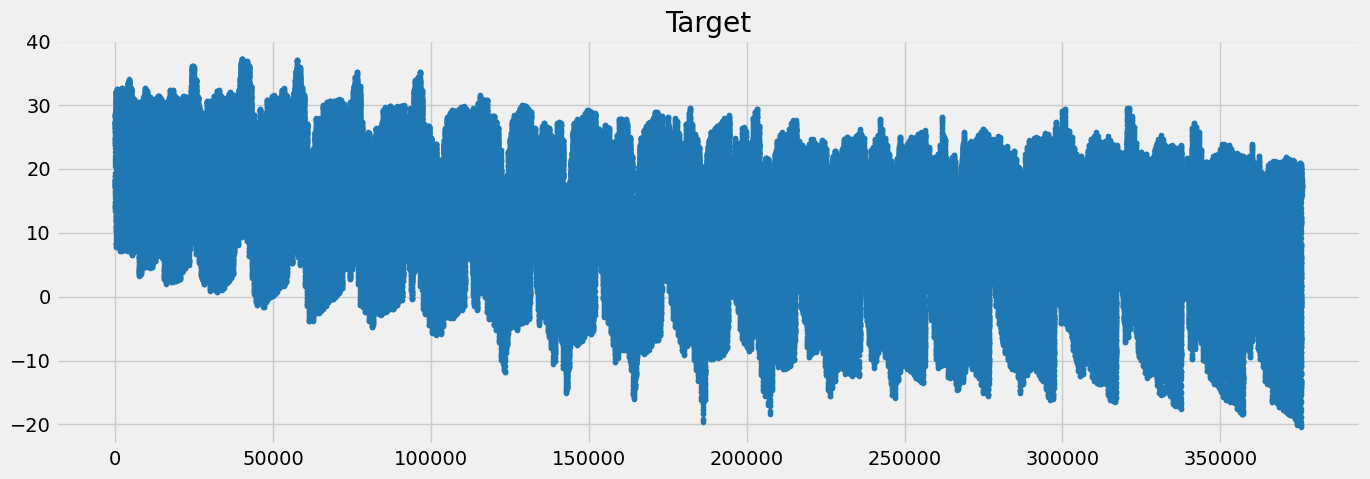

In [14]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
target_p = train["contest-tmp2m-14d__tmp2m"]
train["contest-tmp2m-14d__tmp2m"].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Target')
plt.show()

In [15]:
### try pca
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)
# X_test = scaler.transform(X_test)

# pca = PCA(n_components = 0.7).fit_transform(X)

In [16]:
### split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 100)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(251741, 245)
(123993, 245)
(251741,)
(123993,)


In [51]:
### train the model - XGBoost
model_xgb = xgb.XGBRegressor(booster = 'gbtree',
                             subsample = 0.8,
                             eta = 0.1, 
                             n_estimaters = 15000,
                             colsample_bytree = 0.4,
                             max_depth = 4,
                             tree_method = 'hist',
                             eval_metric = 'rmse', 
                             objective = 'reg:squarederror')

model_xgb.fit(x_train, y_train, eval_set = [(x_train, y_train), (x_test, y_test)], verbose = 100)

[0]	validation_0-rmse:13.6141	validation_1-rmse:13.5705
[99]	validation_0-rmse:1.19661	validation_1-rmse:1.20956


XGBRegressor(colsample_bytree=0.4, eta=0.1, eval_metric='rmse', max_depth=4,
             n_estimaters=15000, objective='reg:squarederror', subsample=0.8,
             tree_method='hist')

In [52]:
### use RMSE to evaluate
y_pred_xgb = model_xgb.predict(x_test)
mean_squared_error(y_pred_xgb, y_test)

1.4630837862612502

In [54]:
### train the model - CatBoost
model_cat = CatBoostRegressor(n_estimators = 15000,
                              eval_metric = 'RMSE',
                              learning_rate = 0.1, 
                              verbose = 1,
                              random_seed = 0).fit(x_train, y_train)

model_cat.fit(x_train, y_train, eval_set = [(x_train, y_train), (x_test, y_test)], verbose = 50)

0:	learn: 9.0046347	total: 84.7ms	remaining: 21m 9s
1:	learn: 8.2224979	total: 156ms	remaining: 19m 32s
2:	learn: 7.5332813	total: 274ms	remaining: 22m 47s
3:	learn: 6.9114455	total: 463ms	remaining: 28m 55s
4:	learn: 6.3541624	total: 558ms	remaining: 27m 53s
5:	learn: 5.8491906	total: 655ms	remaining: 27m 16s
6:	learn: 5.3960346	total: 764ms	remaining: 27m 16s
7:	learn: 4.9916525	total: 861ms	remaining: 26m 53s
8:	learn: 4.6305333	total: 996ms	remaining: 27m 38s
9:	learn: 4.3077721	total: 1.08s	remaining: 27m 3s
10:	learn: 4.0213679	total: 1.18s	remaining: 26m 47s
11:	learn: 3.7690254	total: 1.31s	remaining: 27m 21s
12:	learn: 3.5401239	total: 1.4s	remaining: 26m 58s
13:	learn: 3.3383018	total: 1.48s	remaining: 26m 29s
14:	learn: 3.1572092	total: 1.57s	remaining: 26m 13s
15:	learn: 2.9928686	total: 1.65s	remaining: 25m 49s
16:	learn: 2.8507119	total: 1.74s	remaining: 25m 31s
17:	learn: 2.7248545	total: 1.84s	remaining: 25m 36s
18:	learn: 2.6127642	total: 1.92s	remaining: 25m 11s
19:	l

156:	learn: 1.1028436	total: 13.9s	remaining: 21m 50s
157:	learn: 1.1004532	total: 13.9s	remaining: 21m 49s
158:	learn: 1.0979269	total: 14s	remaining: 21m 50s
159:	learn: 1.0952963	total: 14.1s	remaining: 21m 49s
160:	learn: 1.0921805	total: 14.2s	remaining: 21m 50s
161:	learn: 1.0896920	total: 14.3s	remaining: 21m 48s
162:	learn: 1.0877131	total: 14.4s	remaining: 21m 48s
163:	learn: 1.0857482	total: 14.5s	remaining: 21m 47s
164:	learn: 1.0840942	total: 14.5s	remaining: 21m 45s
165:	learn: 1.0814387	total: 14.6s	remaining: 21m 47s
166:	learn: 1.0789807	total: 14.7s	remaining: 21m 46s
167:	learn: 1.0757293	total: 14.8s	remaining: 21m 45s
168:	learn: 1.0737093	total: 14.9s	remaining: 21m 45s
169:	learn: 1.0714386	total: 15s	remaining: 21m 45s
170:	learn: 1.0695514	total: 15s	remaining: 21m 43s
171:	learn: 1.0675458	total: 15.1s	remaining: 21m 42s
172:	learn: 1.0656762	total: 15.2s	remaining: 21m 41s
173:	learn: 1.0634095	total: 15.3s	remaining: 21m 40s
174:	learn: 1.0615800	total: 15.3s

310:	learn: 0.8636653	total: 26.9s	remaining: 21m 9s
311:	learn: 0.8622952	total: 27s	remaining: 21m 11s
312:	learn: 0.8614861	total: 27.1s	remaining: 21m 11s
313:	learn: 0.8607930	total: 27.2s	remaining: 21m 10s
314:	learn: 0.8598199	total: 27.3s	remaining: 21m 10s
315:	learn: 0.8587624	total: 27.3s	remaining: 21m 10s
316:	learn: 0.8577195	total: 27.4s	remaining: 21m 10s
317:	learn: 0.8569590	total: 27.5s	remaining: 21m 10s
318:	learn: 0.8560638	total: 27.6s	remaining: 21m 10s
319:	learn: 0.8551593	total: 27.7s	remaining: 21m 10s
320:	learn: 0.8540834	total: 27.8s	remaining: 21m 10s
321:	learn: 0.8533886	total: 27.9s	remaining: 21m 9s
322:	learn: 0.8527410	total: 27.9s	remaining: 21m 9s
323:	learn: 0.8517942	total: 28s	remaining: 21m 9s
324:	learn: 0.8508049	total: 28.1s	remaining: 21m 8s
325:	learn: 0.8498989	total: 28.2s	remaining: 21m 8s
326:	learn: 0.8490654	total: 28.3s	remaining: 21m 8s
327:	learn: 0.8485201	total: 28.3s	remaining: 21m 7s
328:	learn: 0.8478354	total: 28.4s	remai

468:	learn: 0.7458644	total: 40.7s	remaining: 21m
469:	learn: 0.7453223	total: 40.8s	remaining: 21m
470:	learn: 0.7446826	total: 40.9s	remaining: 21m
471:	learn: 0.7440033	total: 40.9s	remaining: 21m
472:	learn: 0.7433787	total: 41s	remaining: 20m 59s
473:	learn: 0.7427248	total: 41.1s	remaining: 21m
474:	learn: 0.7418862	total: 41.2s	remaining: 20m 59s
475:	learn: 0.7414577	total: 41.3s	remaining: 20m 59s
476:	learn: 0.7398667	total: 41.4s	remaining: 20m 59s
477:	learn: 0.7392283	total: 41.5s	remaining: 20m 59s
478:	learn: 0.7384557	total: 41.6s	remaining: 21m
479:	learn: 0.7380828	total: 41.7s	remaining: 21m
480:	learn: 0.7373627	total: 41.8s	remaining: 21m
481:	learn: 0.7369070	total: 41.8s	remaining: 21m
482:	learn: 0.7363756	total: 41.9s	remaining: 21m
483:	learn: 0.7359610	total: 42s	remaining: 20m 59s
484:	learn: 0.7352631	total: 42.1s	remaining: 20m 59s
485:	learn: 0.7346629	total: 42.2s	remaining: 20m 59s
486:	learn: 0.7342170	total: 42.3s	remaining: 20m 59s
487:	learn: 0.7337

623:	learn: 0.6698127	total: 53.6s	remaining: 20m 35s
624:	learn: 0.6693437	total: 53.7s	remaining: 20m 35s
625:	learn: 0.6690640	total: 53.8s	remaining: 20m 35s
626:	learn: 0.6687114	total: 53.9s	remaining: 20m 35s
627:	learn: 0.6683529	total: 54s	remaining: 20m 35s
628:	learn: 0.6679231	total: 54.1s	remaining: 20m 35s
629:	learn: 0.6676247	total: 54.1s	remaining: 20m 34s
630:	learn: 0.6672849	total: 54.2s	remaining: 20m 34s
631:	learn: 0.6669170	total: 54.3s	remaining: 20m 35s
632:	learn: 0.6664905	total: 54.4s	remaining: 20m 34s
633:	learn: 0.6660875	total: 54.5s	remaining: 20m 34s
634:	learn: 0.6652470	total: 54.6s	remaining: 20m 34s
635:	learn: 0.6648493	total: 54.7s	remaining: 20m 34s
636:	learn: 0.6642685	total: 54.8s	remaining: 20m 34s
637:	learn: 0.6638607	total: 54.8s	remaining: 20m 34s
638:	learn: 0.6633916	total: 54.9s	remaining: 20m 34s
639:	learn: 0.6629135	total: 55s	remaining: 20m 33s
640:	learn: 0.6626102	total: 55.1s	remaining: 20m 33s
641:	learn: 0.6623077	total: 55.

777:	learn: 0.6158443	total: 1m 6s	remaining: 20m 21s
778:	learn: 0.6155010	total: 1m 6s	remaining: 20m 21s
779:	learn: 0.6151031	total: 1m 6s	remaining: 20m 21s
780:	learn: 0.6147666	total: 1m 7s	remaining: 20m 21s
781:	learn: 0.6145342	total: 1m 7s	remaining: 20m 21s
782:	learn: 0.6142790	total: 1m 7s	remaining: 20m 21s
783:	learn: 0.6138726	total: 1m 7s	remaining: 20m 20s
784:	learn: 0.6136274	total: 1m 7s	remaining: 20m 20s
785:	learn: 0.6132815	total: 1m 7s	remaining: 20m 20s
786:	learn: 0.6130329	total: 1m 7s	remaining: 20m 20s
787:	learn: 0.6127737	total: 1m 7s	remaining: 20m 20s
788:	learn: 0.6123873	total: 1m 7s	remaining: 20m 20s
789:	learn: 0.6121587	total: 1m 7s	remaining: 20m 20s
790:	learn: 0.6119258	total: 1m 7s	remaining: 20m 20s
791:	learn: 0.6116314	total: 1m 8s	remaining: 20m 20s
792:	learn: 0.6113736	total: 1m 8s	remaining: 20m 20s
793:	learn: 0.6110485	total: 1m 8s	remaining: 20m 19s
794:	learn: 0.6106049	total: 1m 8s	remaining: 20m 20s
795:	learn: 0.6103564	total:

928:	learn: 0.5731983	total: 1m 20s	remaining: 20m 13s
929:	learn: 0.5730366	total: 1m 20s	remaining: 20m 13s
930:	learn: 0.5727452	total: 1m 20s	remaining: 20m 13s
931:	learn: 0.5724654	total: 1m 20s	remaining: 20m 13s
932:	learn: 0.5721867	total: 1m 20s	remaining: 20m 13s
933:	learn: 0.5719962	total: 1m 20s	remaining: 20m 13s
934:	learn: 0.5717786	total: 1m 20s	remaining: 20m 13s
935:	learn: 0.5715647	total: 1m 20s	remaining: 20m 12s
936:	learn: 0.5712724	total: 1m 20s	remaining: 20m 12s
937:	learn: 0.5710517	total: 1m 20s	remaining: 20m 12s
938:	learn: 0.5708514	total: 1m 20s	remaining: 20m 12s
939:	learn: 0.5703998	total: 1m 21s	remaining: 20m 12s
940:	learn: 0.5701420	total: 1m 21s	remaining: 20m 11s
941:	learn: 0.5698959	total: 1m 21s	remaining: 20m 11s
942:	learn: 0.5697357	total: 1m 21s	remaining: 20m 11s
943:	learn: 0.5694616	total: 1m 21s	remaining: 20m 11s
944:	learn: 0.5692235	total: 1m 21s	remaining: 20m 11s
945:	learn: 0.5689641	total: 1m 21s	remaining: 20m 11s
946:	learn

1079:	learn: 0.5396398	total: 1m 33s	remaining: 20m 2s
1080:	learn: 0.5394683	total: 1m 33s	remaining: 20m 2s
1081:	learn: 0.5392789	total: 1m 33s	remaining: 20m 2s
1082:	learn: 0.5391467	total: 1m 33s	remaining: 20m 2s
1083:	learn: 0.5389605	total: 1m 33s	remaining: 20m 2s
1084:	learn: 0.5387502	total: 1m 33s	remaining: 20m 2s
1085:	learn: 0.5385757	total: 1m 33s	remaining: 20m 3s
1086:	learn: 0.5383822	total: 1m 34s	remaining: 20m 3s
1087:	learn: 0.5382335	total: 1m 34s	remaining: 20m 3s
1088:	learn: 0.5380543	total: 1m 34s	remaining: 20m 2s
1089:	learn: 0.5379335	total: 1m 34s	remaining: 20m 2s
1090:	learn: 0.5377145	total: 1m 34s	remaining: 20m 2s
1091:	learn: 0.5375406	total: 1m 34s	remaining: 20m 2s
1092:	learn: 0.5372703	total: 1m 34s	remaining: 20m 2s
1093:	learn: 0.5371075	total: 1m 34s	remaining: 20m 2s
1094:	learn: 0.5368285	total: 1m 34s	remaining: 20m 2s
1095:	learn: 0.5366392	total: 1m 34s	remaining: 20m 2s
1096:	learn: 0.5364551	total: 1m 34s	remaining: 20m 2s
1097:	lear

1229:	learn: 0.5114063	total: 1m 47s	remaining: 20m 4s
1230:	learn: 0.5111917	total: 1m 47s	remaining: 20m 4s
1231:	learn: 0.5109431	total: 1m 47s	remaining: 20m 4s
1232:	learn: 0.5107627	total: 1m 47s	remaining: 20m 4s
1233:	learn: 0.5105695	total: 1m 48s	remaining: 20m 4s
1234:	learn: 0.5104105	total: 1m 48s	remaining: 20m 4s
1235:	learn: 0.5102636	total: 1m 48s	remaining: 20m 4s
1236:	learn: 0.5100274	total: 1m 48s	remaining: 20m 5s
1237:	learn: 0.5098266	total: 1m 48s	remaining: 20m 5s
1238:	learn: 0.5096760	total: 1m 48s	remaining: 20m 5s
1239:	learn: 0.5094975	total: 1m 48s	remaining: 20m 5s
1240:	learn: 0.5093103	total: 1m 48s	remaining: 20m 5s
1241:	learn: 0.5091337	total: 1m 48s	remaining: 20m 5s
1242:	learn: 0.5089500	total: 1m 48s	remaining: 20m 5s
1243:	learn: 0.5088026	total: 1m 48s	remaining: 20m 5s
1244:	learn: 0.5086598	total: 1m 49s	remaining: 20m 5s
1245:	learn: 0.5085187	total: 1m 49s	remaining: 20m 5s
1246:	learn: 0.5083462	total: 1m 49s	remaining: 20m 5s
1247:	lear

1379:	learn: 0.4864088	total: 2m	remaining: 19m 50s
1380:	learn: 0.4862198	total: 2m	remaining: 19m 50s
1381:	learn: 0.4860753	total: 2m	remaining: 19m 49s
1382:	learn: 0.4858615	total: 2m	remaining: 19m 49s
1383:	learn: 0.4857362	total: 2m	remaining: 19m 49s
1384:	learn: 0.4855690	total: 2m 1s	remaining: 19m 49s
1385:	learn: 0.4854276	total: 2m 1s	remaining: 19m 49s
1386:	learn: 0.4852305	total: 2m 1s	remaining: 19m 49s
1387:	learn: 0.4849412	total: 2m 1s	remaining: 19m 49s
1388:	learn: 0.4848478	total: 2m 1s	remaining: 19m 49s
1389:	learn: 0.4847159	total: 2m 1s	remaining: 19m 49s
1390:	learn: 0.4845920	total: 2m 1s	remaining: 19m 48s
1391:	learn: 0.4844317	total: 2m 1s	remaining: 19m 48s
1392:	learn: 0.4842950	total: 2m 1s	remaining: 19m 48s
1393:	learn: 0.4841038	total: 2m 1s	remaining: 19m 48s
1394:	learn: 0.4839891	total: 2m 1s	remaining: 19m 48s
1395:	learn: 0.4838432	total: 2m 1s	remaining: 19m 48s
1396:	learn: 0.4835920	total: 2m 2s	remaining: 19m 48s
1397:	learn: 0.4834825	to

1528:	learn: 0.4653675	total: 2m 13s	remaining: 19m 32s
1529:	learn: 0.4652398	total: 2m 13s	remaining: 19m 32s
1530:	learn: 0.4651504	total: 2m 13s	remaining: 19m 32s
1531:	learn: 0.4650094	total: 2m 13s	remaining: 19m 32s
1532:	learn: 0.4648721	total: 2m 13s	remaining: 19m 32s
1533:	learn: 0.4647620	total: 2m 13s	remaining: 19m 32s
1534:	learn: 0.4646404	total: 2m 13s	remaining: 19m 32s
1535:	learn: 0.4645069	total: 2m 13s	remaining: 19m 32s
1536:	learn: 0.4643759	total: 2m 13s	remaining: 19m 31s
1537:	learn: 0.4642556	total: 2m 13s	remaining: 19m 31s
1538:	learn: 0.4641485	total: 2m 13s	remaining: 19m 31s
1539:	learn: 0.4640250	total: 2m 14s	remaining: 19m 31s
1540:	learn: 0.4638895	total: 2m 14s	remaining: 19m 31s
1541:	learn: 0.4637857	total: 2m 14s	remaining: 19m 31s
1542:	learn: 0.4636792	total: 2m 14s	remaining: 19m 30s
1543:	learn: 0.4635800	total: 2m 14s	remaining: 19m 30s
1544:	learn: 0.4634242	total: 2m 14s	remaining: 19m 30s
1545:	learn: 0.4632776	total: 2m 14s	remaining: 

1677:	learn: 0.4470574	total: 2m 25s	remaining: 19m 16s
1678:	learn: 0.4469668	total: 2m 25s	remaining: 19m 16s
1679:	learn: 0.4468580	total: 2m 25s	remaining: 19m 16s
1680:	learn: 0.4467211	total: 2m 25s	remaining: 19m 16s
1681:	learn: 0.4465876	total: 2m 26s	remaining: 19m 16s
1682:	learn: 0.4464537	total: 2m 26s	remaining: 19m 16s
1683:	learn: 0.4463238	total: 2m 26s	remaining: 19m 16s
1684:	learn: 0.4462041	total: 2m 26s	remaining: 19m 16s
1685:	learn: 0.4461030	total: 2m 26s	remaining: 19m 16s
1686:	learn: 0.4460121	total: 2m 26s	remaining: 19m 15s
1687:	learn: 0.4459234	total: 2m 26s	remaining: 19m 15s
1688:	learn: 0.4458428	total: 2m 26s	remaining: 19m 15s
1689:	learn: 0.4457542	total: 2m 26s	remaining: 19m 15s
1690:	learn: 0.4456323	total: 2m 26s	remaining: 19m 15s
1691:	learn: 0.4454712	total: 2m 26s	remaining: 19m 15s
1692:	learn: 0.4453713	total: 2m 26s	remaining: 19m 15s
1693:	learn: 0.4452772	total: 2m 27s	remaining: 19m 15s
1694:	learn: 0.4451856	total: 2m 27s	remaining: 

1825:	learn: 0.4301421	total: 2m 38s	remaining: 19m 2s
1826:	learn: 0.4299746	total: 2m 38s	remaining: 19m 2s
1827:	learn: 0.4298401	total: 2m 38s	remaining: 19m 2s
1828:	learn: 0.4297408	total: 2m 38s	remaining: 19m 2s
1829:	learn: 0.4296629	total: 2m 38s	remaining: 19m 2s
1830:	learn: 0.4295744	total: 2m 38s	remaining: 19m 2s
1831:	learn: 0.4294620	total: 2m 38s	remaining: 19m 2s
1832:	learn: 0.4293797	total: 2m 38s	remaining: 19m 2s
1833:	learn: 0.4292636	total: 2m 39s	remaining: 19m 1s
1834:	learn: 0.4291287	total: 2m 39s	remaining: 19m 1s
1835:	learn: 0.4290076	total: 2m 39s	remaining: 19m 1s
1836:	learn: 0.4289152	total: 2m 39s	remaining: 19m 1s
1837:	learn: 0.4288413	total: 2m 39s	remaining: 19m 1s
1838:	learn: 0.4287424	total: 2m 39s	remaining: 19m 1s
1839:	learn: 0.4286486	total: 2m 39s	remaining: 19m 1s
1840:	learn: 0.4285666	total: 2m 39s	remaining: 19m 1s
1841:	learn: 0.4284803	total: 2m 39s	remaining: 19m
1842:	learn: 0.4283873	total: 2m 39s	remaining: 19m
1843:	learn: 0.4

1974:	learn: 0.4148800	total: 2m 51s	remaining: 18m 48s
1975:	learn: 0.4147588	total: 2m 51s	remaining: 18m 48s
1976:	learn: 0.4146348	total: 2m 51s	remaining: 18m 48s
1977:	learn: 0.4145535	total: 2m 51s	remaining: 18m 48s
1978:	learn: 0.4144566	total: 2m 51s	remaining: 18m 48s
1979:	learn: 0.4143389	total: 2m 51s	remaining: 18m 48s
1980:	learn: 0.4142673	total: 2m 51s	remaining: 18m 48s
1981:	learn: 0.4141779	total: 2m 51s	remaining: 18m 48s
1982:	learn: 0.4140914	total: 2m 51s	remaining: 18m 47s
1983:	learn: 0.4140165	total: 2m 51s	remaining: 18m 47s
1984:	learn: 0.4139410	total: 2m 51s	remaining: 18m 47s
1985:	learn: 0.4138687	total: 2m 52s	remaining: 18m 47s
1986:	learn: 0.4137638	total: 2m 52s	remaining: 18m 47s
1987:	learn: 0.4136691	total: 2m 52s	remaining: 18m 47s
1988:	learn: 0.4135463	total: 2m 52s	remaining: 18m 47s
1989:	learn: 0.4134626	total: 2m 52s	remaining: 18m 47s
1990:	learn: 0.4133539	total: 2m 52s	remaining: 18m 47s
1991:	learn: 0.4132639	total: 2m 52s	remaining: 

2124:	learn: 0.4009469	total: 3m 4s	remaining: 18m 36s
2125:	learn: 0.4008817	total: 3m 4s	remaining: 18m 35s
2126:	learn: 0.4008032	total: 3m 4s	remaining: 18m 35s
2127:	learn: 0.4007470	total: 3m 4s	remaining: 18m 35s
2128:	learn: 0.4006618	total: 3m 4s	remaining: 18m 35s
2129:	learn: 0.4006067	total: 3m 4s	remaining: 18m 35s
2130:	learn: 0.4005131	total: 3m 4s	remaining: 18m 35s
2131:	learn: 0.4004415	total: 3m 4s	remaining: 18m 35s
2132:	learn: 0.4003212	total: 3m 4s	remaining: 18m 35s
2133:	learn: 0.4002230	total: 3m 4s	remaining: 18m 35s
2134:	learn: 0.4001512	total: 3m 5s	remaining: 18m 34s
2135:	learn: 0.4000915	total: 3m 5s	remaining: 18m 34s
2136:	learn: 0.4000201	total: 3m 5s	remaining: 18m 34s
2137:	learn: 0.3999408	total: 3m 5s	remaining: 18m 34s
2138:	learn: 0.3998426	total: 3m 5s	remaining: 18m 34s
2139:	learn: 0.3997670	total: 3m 5s	remaining: 18m 34s
2140:	learn: 0.3996765	total: 3m 5s	remaining: 18m 34s
2141:	learn: 0.3996018	total: 3m 5s	remaining: 18m 34s
2142:	lear

2273:	learn: 0.3886603	total: 3m 16s	remaining: 18m 21s
2274:	learn: 0.3885702	total: 3m 16s	remaining: 18m 21s
2275:	learn: 0.3884729	total: 3m 17s	remaining: 18m 21s
2276:	learn: 0.3884101	total: 3m 17s	remaining: 18m 21s
2277:	learn: 0.3883393	total: 3m 17s	remaining: 18m 21s
2278:	learn: 0.3882626	total: 3m 17s	remaining: 18m 21s
2279:	learn: 0.3881897	total: 3m 17s	remaining: 18m 21s
2280:	learn: 0.3881021	total: 3m 17s	remaining: 18m 21s
2281:	learn: 0.3880345	total: 3m 17s	remaining: 18m 21s
2282:	learn: 0.3879355	total: 3m 17s	remaining: 18m 21s
2283:	learn: 0.3878643	total: 3m 17s	remaining: 18m 20s
2284:	learn: 0.3877926	total: 3m 17s	remaining: 18m 20s
2285:	learn: 0.3877314	total: 3m 17s	remaining: 18m 20s
2286:	learn: 0.3876418	total: 3m 17s	remaining: 18m 20s
2287:	learn: 0.3874592	total: 3m 18s	remaining: 18m 20s
2288:	learn: 0.3873496	total: 3m 18s	remaining: 18m 20s
2289:	learn: 0.3872994	total: 3m 18s	remaining: 18m 20s
2290:	learn: 0.3872087	total: 3m 18s	remaining: 

2420:	learn: 0.3771286	total: 3m 30s	remaining: 18m 12s
2421:	learn: 0.3770329	total: 3m 30s	remaining: 18m 12s
2422:	learn: 0.3769707	total: 3m 30s	remaining: 18m 12s
2423:	learn: 0.3768986	total: 3m 30s	remaining: 18m 12s
2424:	learn: 0.3768144	total: 3m 30s	remaining: 18m 11s
2425:	learn: 0.3767562	total: 3m 30s	remaining: 18m 11s
2426:	learn: 0.3766762	total: 3m 30s	remaining: 18m 11s
2427:	learn: 0.3765911	total: 3m 30s	remaining: 18m 11s
2428:	learn: 0.3765050	total: 3m 30s	remaining: 18m 11s
2429:	learn: 0.3764121	total: 3m 31s	remaining: 18m 11s
2430:	learn: 0.3763440	total: 3m 31s	remaining: 18m 11s
2431:	learn: 0.3762163	total: 3m 31s	remaining: 18m 11s
2432:	learn: 0.3761316	total: 3m 31s	remaining: 18m 11s
2433:	learn: 0.3760668	total: 3m 31s	remaining: 18m 11s
2434:	learn: 0.3759797	total: 3m 31s	remaining: 18m 11s
2435:	learn: 0.3759198	total: 3m 31s	remaining: 18m 11s
2436:	learn: 0.3758145	total: 3m 31s	remaining: 18m 10s
2437:	learn: 0.3757548	total: 3m 31s	remaining: 

2569:	learn: 0.3665358	total: 3m 43s	remaining: 17m 58s
2570:	learn: 0.3664636	total: 3m 43s	remaining: 17m 58s
2571:	learn: 0.3664084	total: 3m 43s	remaining: 17m 58s
2572:	learn: 0.3663545	total: 3m 43s	remaining: 17m 58s
2573:	learn: 0.3663039	total: 3m 43s	remaining: 17m 58s
2574:	learn: 0.3662549	total: 3m 43s	remaining: 17m 58s
2575:	learn: 0.3661745	total: 3m 43s	remaining: 17m 58s
2576:	learn: 0.3661109	total: 3m 43s	remaining: 17m 57s
2577:	learn: 0.3660583	total: 3m 43s	remaining: 17m 57s
2578:	learn: 0.3659919	total: 3m 43s	remaining: 17m 57s
2579:	learn: 0.3659311	total: 3m 43s	remaining: 17m 57s
2580:	learn: 0.3658774	total: 3m 43s	remaining: 17m 57s
2581:	learn: 0.3657812	total: 3m 44s	remaining: 17m 57s
2582:	learn: 0.3657391	total: 3m 44s	remaining: 17m 57s
2583:	learn: 0.3656578	total: 3m 44s	remaining: 17m 57s
2584:	learn: 0.3655790	total: 3m 44s	remaining: 17m 57s
2585:	learn: 0.3655231	total: 3m 44s	remaining: 17m 57s
2586:	learn: 0.3654318	total: 3m 44s	remaining: 

2717:	learn: 0.3564716	total: 3m 55s	remaining: 17m 45s
2718:	learn: 0.3564024	total: 3m 55s	remaining: 17m 45s
2719:	learn: 0.3563519	total: 3m 55s	remaining: 17m 45s
2720:	learn: 0.3563018	total: 3m 56s	remaining: 17m 45s
2721:	learn: 0.3562515	total: 3m 56s	remaining: 17m 45s
2722:	learn: 0.3561786	total: 3m 56s	remaining: 17m 44s
2723:	learn: 0.3560882	total: 3m 56s	remaining: 17m 44s
2724:	learn: 0.3560318	total: 3m 56s	remaining: 17m 44s
2725:	learn: 0.3559583	total: 3m 56s	remaining: 17m 44s
2726:	learn: 0.3559117	total: 3m 56s	remaining: 17m 44s
2727:	learn: 0.3558711	total: 3m 56s	remaining: 17m 44s
2728:	learn: 0.3558181	total: 3m 56s	remaining: 17m 44s
2729:	learn: 0.3557463	total: 3m 56s	remaining: 17m 44s
2730:	learn: 0.3556860	total: 3m 56s	remaining: 17m 43s
2731:	learn: 0.3555858	total: 3m 56s	remaining: 17m 43s
2732:	learn: 0.3555240	total: 3m 56s	remaining: 17m 43s
2733:	learn: 0.3554710	total: 3m 57s	remaining: 17m 43s
2734:	learn: 0.3554286	total: 3m 57s	remaining: 

2866:	learn: 0.3473489	total: 4m 8s	remaining: 17m 30s
2867:	learn: 0.3472869	total: 4m 8s	remaining: 17m 30s
2868:	learn: 0.3472441	total: 4m 8s	remaining: 17m 30s
2869:	learn: 0.3472014	total: 4m 8s	remaining: 17m 30s
2870:	learn: 0.3471180	total: 4m 8s	remaining: 17m 30s
2871:	learn: 0.3470614	total: 4m 8s	remaining: 17m 30s
2872:	learn: 0.3470160	total: 4m 8s	remaining: 17m 29s
2873:	learn: 0.3469476	total: 4m 8s	remaining: 17m 29s
2874:	learn: 0.3468852	total: 4m 8s	remaining: 17m 29s
2875:	learn: 0.3468294	total: 4m 9s	remaining: 17m 29s
2876:	learn: 0.3467723	total: 4m 9s	remaining: 17m 29s
2877:	learn: 0.3467175	total: 4m 9s	remaining: 17m 29s
2878:	learn: 0.3466632	total: 4m 9s	remaining: 17m 29s
2879:	learn: 0.3466143	total: 4m 9s	remaining: 17m 29s
2880:	learn: 0.3465506	total: 4m 9s	remaining: 17m 29s
2881:	learn: 0.3464991	total: 4m 9s	remaining: 17m 29s
2882:	learn: 0.3464469	total: 4m 9s	remaining: 17m 29s
2883:	learn: 0.3463633	total: 4m 9s	remaining: 17m 28s
2884:	lear

3013:	learn: 0.3389151	total: 4m 20s	remaining: 17m 15s
3014:	learn: 0.3388296	total: 4m 20s	remaining: 17m 14s
3015:	learn: 0.3387984	total: 4m 20s	remaining: 17m 15s
3016:	learn: 0.3387492	total: 4m 20s	remaining: 17m 14s
3017:	learn: 0.3386910	total: 4m 20s	remaining: 17m 14s
3018:	learn: 0.3386162	total: 4m 20s	remaining: 17m 14s
3019:	learn: 0.3385578	total: 4m 20s	remaining: 17m 14s
3020:	learn: 0.3385052	total: 4m 20s	remaining: 17m 14s
3021:	learn: 0.3384574	total: 4m 20s	remaining: 17m 14s
3022:	learn: 0.3384045	total: 4m 21s	remaining: 17m 14s
3023:	learn: 0.3383062	total: 4m 21s	remaining: 17m 14s
3024:	learn: 0.3382471	total: 4m 21s	remaining: 17m 14s
3025:	learn: 0.3382064	total: 4m 21s	remaining: 17m 14s
3026:	learn: 0.3381263	total: 4m 21s	remaining: 17m 13s
3027:	learn: 0.3380593	total: 4m 21s	remaining: 17m 13s
3028:	learn: 0.3379805	total: 4m 21s	remaining: 17m 13s
3029:	learn: 0.3379369	total: 4m 21s	remaining: 17m 13s
3030:	learn: 0.3378751	total: 4m 21s	remaining: 

3163:	learn: 0.3304778	total: 4m 32s	remaining: 17m
3164:	learn: 0.3304151	total: 4m 32s	remaining: 17m
3165:	learn: 0.3303641	total: 4m 33s	remaining: 17m
3166:	learn: 0.3303070	total: 4m 33s	remaining: 17m
3167:	learn: 0.3302706	total: 4m 33s	remaining: 17m
3168:	learn: 0.3302135	total: 4m 33s	remaining: 17m
3169:	learn: 0.3301782	total: 4m 33s	remaining: 17m
3170:	learn: 0.3301313	total: 4m 33s	remaining: 16m 59s
3171:	learn: 0.3300588	total: 4m 33s	remaining: 16m 59s
3172:	learn: 0.3299973	total: 4m 33s	remaining: 16m 59s
3173:	learn: 0.3299528	total: 4m 33s	remaining: 16m 59s
3174:	learn: 0.3299032	total: 4m 33s	remaining: 16m 59s
3175:	learn: 0.3298569	total: 4m 33s	remaining: 16m 59s
3176:	learn: 0.3298094	total: 4m 33s	remaining: 16m 59s
3177:	learn: 0.3297110	total: 4m 34s	remaining: 16m 59s
3178:	learn: 0.3296403	total: 4m 34s	remaining: 16m 59s
3179:	learn: 0.3295675	total: 4m 34s	remaining: 16m 59s
3180:	learn: 0.3295187	total: 4m 34s	remaining: 16m 59s
3181:	learn: 0.32944

3311:	learn: 0.3229739	total: 4m 45s	remaining: 16m 46s
3312:	learn: 0.3229075	total: 4m 45s	remaining: 16m 46s
3313:	learn: 0.3228633	total: 4m 45s	remaining: 16m 46s
3314:	learn: 0.3228149	total: 4m 45s	remaining: 16m 47s
3315:	learn: 0.3227696	total: 4m 45s	remaining: 16m 47s
3316:	learn: 0.3227223	total: 4m 45s	remaining: 16m 47s
3317:	learn: 0.3226643	total: 4m 46s	remaining: 16m 47s
3318:	learn: 0.3226206	total: 4m 46s	remaining: 16m 47s
3319:	learn: 0.3225744	total: 4m 46s	remaining: 16m 47s
3320:	learn: 0.3225170	total: 4m 46s	remaining: 16m 47s
3321:	learn: 0.3224610	total: 4m 46s	remaining: 16m 47s
3322:	learn: 0.3224292	total: 4m 46s	remaining: 16m 46s
3323:	learn: 0.3223783	total: 4m 46s	remaining: 16m 46s
3324:	learn: 0.3223211	total: 4m 46s	remaining: 16m 46s
3325:	learn: 0.3222707	total: 4m 46s	remaining: 16m 46s
3326:	learn: 0.3222072	total: 4m 46s	remaining: 16m 46s
3327:	learn: 0.3221619	total: 4m 47s	remaining: 16m 46s
3328:	learn: 0.3221025	total: 4m 47s	remaining: 

3460:	learn: 0.3157570	total: 4m 58s	remaining: 16m 36s
3461:	learn: 0.3156877	total: 4m 59s	remaining: 16m 36s
3462:	learn: 0.3156277	total: 4m 59s	remaining: 16m 36s
3463:	learn: 0.3155822	total: 4m 59s	remaining: 16m 36s
3464:	learn: 0.3155339	total: 4m 59s	remaining: 16m 36s
3465:	learn: 0.3154867	total: 4m 59s	remaining: 16m 36s
3466:	learn: 0.3154504	total: 4m 59s	remaining: 16m 36s
3467:	learn: 0.3154110	total: 4m 59s	remaining: 16m 36s
3468:	learn: 0.3153483	total: 4m 59s	remaining: 16m 36s
3469:	learn: 0.3152956	total: 4m 59s	remaining: 16m 36s
3470:	learn: 0.3152539	total: 4m 59s	remaining: 16m 36s
3471:	learn: 0.3151665	total: 5m	remaining: 16m 36s
3472:	learn: 0.3151113	total: 5m	remaining: 16m 36s
3473:	learn: 0.3150739	total: 5m	remaining: 16m 35s
3474:	learn: 0.3150326	total: 5m	remaining: 16m 35s
3475:	learn: 0.3149907	total: 5m	remaining: 16m 35s
3476:	learn: 0.3149549	total: 5m	remaining: 16m 35s
3477:	learn: 0.3148970	total: 5m	remaining: 16m 35s
3478:	learn: 0.31486

3610:	learn: 0.3090278	total: 5m 13s	remaining: 16m 28s
3611:	learn: 0.3089837	total: 5m 13s	remaining: 16m 28s
3612:	learn: 0.3089461	total: 5m 13s	remaining: 16m 28s
3613:	learn: 0.3089134	total: 5m 13s	remaining: 16m 28s
3614:	learn: 0.3087958	total: 5m 13s	remaining: 16m 28s
3615:	learn: 0.3087546	total: 5m 13s	remaining: 16m 28s
3616:	learn: 0.3087154	total: 5m 14s	remaining: 16m 28s
3617:	learn: 0.3086795	total: 5m 14s	remaining: 16m 28s
3618:	learn: 0.3086341	total: 5m 14s	remaining: 16m 28s
3619:	learn: 0.3085915	total: 5m 14s	remaining: 16m 28s
3620:	learn: 0.3085608	total: 5m 14s	remaining: 16m 28s
3621:	learn: 0.3085185	total: 5m 14s	remaining: 16m 28s
3622:	learn: 0.3084647	total: 5m 14s	remaining: 16m 27s
3623:	learn: 0.3084156	total: 5m 14s	remaining: 16m 27s
3624:	learn: 0.3083747	total: 5m 14s	remaining: 16m 27s
3625:	learn: 0.3083195	total: 5m 14s	remaining: 16m 27s
3626:	learn: 0.3082702	total: 5m 15s	remaining: 16m 27s
3627:	learn: 0.3082192	total: 5m 15s	remaining: 

3759:	learn: 0.3022233	total: 5m 27s	remaining: 16m 18s
3760:	learn: 0.3021933	total: 5m 27s	remaining: 16m 18s
3761:	learn: 0.3021629	total: 5m 27s	remaining: 16m 18s
3762:	learn: 0.3021180	total: 5m 27s	remaining: 16m 18s
3763:	learn: 0.3020826	total: 5m 27s	remaining: 16m 18s
3764:	learn: 0.3020290	total: 5m 27s	remaining: 16m 18s
3765:	learn: 0.3019943	total: 5m 27s	remaining: 16m 18s
3766:	learn: 0.3019484	total: 5m 28s	remaining: 16m 18s
3767:	learn: 0.3019082	total: 5m 28s	remaining: 16m 18s
3768:	learn: 0.3018510	total: 5m 28s	remaining: 16m 18s
3769:	learn: 0.3018164	total: 5m 28s	remaining: 16m 17s
3770:	learn: 0.3017740	total: 5m 28s	remaining: 16m 17s
3771:	learn: 0.3017320	total: 5m 28s	remaining: 16m 17s
3772:	learn: 0.3017019	total: 5m 28s	remaining: 16m 17s
3773:	learn: 0.3016559	total: 5m 28s	remaining: 16m 17s
3774:	learn: 0.3016234	total: 5m 28s	remaining: 16m 17s
3775:	learn: 0.3015758	total: 5m 28s	remaining: 16m 17s
3776:	learn: 0.3015384	total: 5m 28s	remaining: 

3907:	learn: 0.2960880	total: 5m 40s	remaining: 16m 5s
3908:	learn: 0.2960085	total: 5m 40s	remaining: 16m 5s
3909:	learn: 0.2959449	total: 5m 40s	remaining: 16m 5s
3910:	learn: 0.2959003	total: 5m 40s	remaining: 16m 5s
3911:	learn: 0.2958750	total: 5m 40s	remaining: 16m 5s
3912:	learn: 0.2958258	total: 5m 40s	remaining: 16m 5s
3913:	learn: 0.2957543	total: 5m 40s	remaining: 16m 5s
3914:	learn: 0.2957118	total: 5m 41s	remaining: 16m 5s
3915:	learn: 0.2956647	total: 5m 41s	remaining: 16m 5s
3916:	learn: 0.2956386	total: 5m 41s	remaining: 16m 5s
3917:	learn: 0.2955973	total: 5m 41s	remaining: 16m 5s
3918:	learn: 0.2955608	total: 5m 41s	remaining: 16m 5s
3919:	learn: 0.2955271	total: 5m 41s	remaining: 16m 5s
3920:	learn: 0.2954909	total: 5m 41s	remaining: 16m 5s
3921:	learn: 0.2954565	total: 5m 41s	remaining: 16m 5s
3922:	learn: 0.2954124	total: 5m 41s	remaining: 16m 5s
3923:	learn: 0.2953633	total: 5m 41s	remaining: 16m 5s
3924:	learn: 0.2953066	total: 5m 42s	remaining: 16m 5s
3925:	lear

4057:	learn: 0.2903497	total: 5m 54s	remaining: 15m 55s
4058:	learn: 0.2903024	total: 5m 54s	remaining: 15m 55s
4059:	learn: 0.2902417	total: 5m 54s	remaining: 15m 55s
4060:	learn: 0.2901936	total: 5m 54s	remaining: 15m 55s
4061:	learn: 0.2901528	total: 5m 54s	remaining: 15m 55s
4062:	learn: 0.2901226	total: 5m 54s	remaining: 15m 55s
4063:	learn: 0.2900750	total: 5m 54s	remaining: 15m 55s
4064:	learn: 0.2900317	total: 5m 55s	remaining: 15m 55s
4065:	learn: 0.2900006	total: 5m 55s	remaining: 15m 54s
4066:	learn: 0.2899739	total: 5m 55s	remaining: 15m 54s
4067:	learn: 0.2899519	total: 5m 55s	remaining: 15m 54s
4068:	learn: 0.2899168	total: 5m 55s	remaining: 15m 54s
4069:	learn: 0.2898760	total: 5m 55s	remaining: 15m 54s
4070:	learn: 0.2898423	total: 5m 55s	remaining: 15m 54s
4071:	learn: 0.2897233	total: 5m 55s	remaining: 15m 54s
4072:	learn: 0.2896863	total: 5m 55s	remaining: 15m 54s
4073:	learn: 0.2896476	total: 5m 55s	remaining: 15m 54s
4074:	learn: 0.2896186	total: 5m 55s	remaining: 

4208:	learn: 0.2845579	total: 6m 7s	remaining: 15m 43s
4209:	learn: 0.2845187	total: 6m 7s	remaining: 15m 42s
4210:	learn: 0.2844529	total: 6m 8s	remaining: 15m 42s
4211:	learn: 0.2844178	total: 6m 8s	remaining: 15m 42s
4212:	learn: 0.2843818	total: 6m 8s	remaining: 15m 42s
4213:	learn: 0.2843496	total: 6m 8s	remaining: 15m 42s
4214:	learn: 0.2843170	total: 6m 8s	remaining: 15m 42s
4215:	learn: 0.2842836	total: 6m 8s	remaining: 15m 42s
4216:	learn: 0.2842502	total: 6m 8s	remaining: 15m 42s
4217:	learn: 0.2842068	total: 6m 8s	remaining: 15m 42s
4218:	learn: 0.2841776	total: 6m 8s	remaining: 15m 42s
4219:	learn: 0.2841351	total: 6m 8s	remaining: 15m 41s
4220:	learn: 0.2841060	total: 6m 8s	remaining: 15m 41s
4221:	learn: 0.2840712	total: 6m 8s	remaining: 15m 41s
4222:	learn: 0.2840448	total: 6m 8s	remaining: 15m 41s
4223:	learn: 0.2840160	total: 6m 9s	remaining: 15m 41s
4224:	learn: 0.2839818	total: 6m 9s	remaining: 15m 41s
4225:	learn: 0.2839460	total: 6m 9s	remaining: 15m 41s
4226:	lear

4355:	learn: 0.2794400	total: 6m 20s	remaining: 15m 28s
4356:	learn: 0.2794129	total: 6m 20s	remaining: 15m 28s
4357:	learn: 0.2793833	total: 6m 20s	remaining: 15m 28s
4358:	learn: 0.2793569	total: 6m 20s	remaining: 15m 28s
4359:	learn: 0.2793284	total: 6m 20s	remaining: 15m 28s
4360:	learn: 0.2793098	total: 6m 20s	remaining: 15m 28s
4361:	learn: 0.2792832	total: 6m 20s	remaining: 15m 27s
4362:	learn: 0.2792397	total: 6m 20s	remaining: 15m 27s
4363:	learn: 0.2791979	total: 6m 20s	remaining: 15m 27s
4364:	learn: 0.2791588	total: 6m 20s	remaining: 15m 27s
4365:	learn: 0.2791339	total: 6m 20s	remaining: 15m 27s
4366:	learn: 0.2791032	total: 6m 20s	remaining: 15m 27s
4367:	learn: 0.2790707	total: 6m 21s	remaining: 15m 27s
4368:	learn: 0.2790361	total: 6m 21s	remaining: 15m 27s
4369:	learn: 0.2790027	total: 6m 21s	remaining: 15m 27s
4370:	learn: 0.2789582	total: 6m 21s	remaining: 15m 27s
4371:	learn: 0.2789412	total: 6m 21s	remaining: 15m 27s
4372:	learn: 0.2789018	total: 6m 21s	remaining: 

4502:	learn: 0.2744104	total: 6m 33s	remaining: 15m 18s
4503:	learn: 0.2743711	total: 6m 33s	remaining: 15m 17s
4504:	learn: 0.2743416	total: 6m 33s	remaining: 15m 17s
4505:	learn: 0.2743138	total: 6m 34s	remaining: 15m 17s
4506:	learn: 0.2742848	total: 6m 34s	remaining: 15m 17s
4507:	learn: 0.2742485	total: 6m 34s	remaining: 15m 17s
4508:	learn: 0.2742222	total: 6m 34s	remaining: 15m 17s
4509:	learn: 0.2741905	total: 6m 34s	remaining: 15m 17s
4510:	learn: 0.2741539	total: 6m 34s	remaining: 15m 17s
4511:	learn: 0.2741156	total: 6m 34s	remaining: 15m 17s
4512:	learn: 0.2740919	total: 6m 34s	remaining: 15m 16s
4513:	learn: 0.2740676	total: 6m 34s	remaining: 15m 16s
4514:	learn: 0.2740339	total: 6m 34s	remaining: 15m 16s
4515:	learn: 0.2740081	total: 6m 34s	remaining: 15m 16s
4516:	learn: 0.2739833	total: 6m 34s	remaining: 15m 16s
4517:	learn: 0.2739631	total: 6m 35s	remaining: 15m 16s
4518:	learn: 0.2739224	total: 6m 35s	remaining: 15m 16s
4519:	learn: 0.2738888	total: 6m 35s	remaining: 

4650:	learn: 0.2697343	total: 6m 49s	remaining: 15m 10s
4651:	learn: 0.2697052	total: 6m 49s	remaining: 15m 10s
4652:	learn: 0.2696814	total: 6m 49s	remaining: 15m 10s
4653:	learn: 0.2696459	total: 6m 49s	remaining: 15m 10s
4654:	learn: 0.2696081	total: 6m 49s	remaining: 15m 10s
4655:	learn: 0.2695824	total: 6m 49s	remaining: 15m 10s
4656:	learn: 0.2695581	total: 6m 50s	remaining: 15m 10s
4657:	learn: 0.2695345	total: 6m 50s	remaining: 15m 10s
4658:	learn: 0.2695092	total: 6m 50s	remaining: 15m 10s
4659:	learn: 0.2694801	total: 6m 50s	remaining: 15m 10s
4660:	learn: 0.2694503	total: 6m 50s	remaining: 15m 10s
4661:	learn: 0.2694199	total: 6m 50s	remaining: 15m 10s
4662:	learn: 0.2693863	total: 6m 50s	remaining: 15m 10s
4663:	learn: 0.2693615	total: 6m 51s	remaining: 15m 10s
4664:	learn: 0.2693215	total: 6m 51s	remaining: 15m 10s
4665:	learn: 0.2692867	total: 6m 51s	remaining: 15m 10s
4666:	learn: 0.2692562	total: 6m 51s	remaining: 15m 10s
4667:	learn: 0.2692320	total: 6m 51s	remaining: 

4802:	learn: 0.2648908	total: 7m 6s	remaining: 15m 6s
4803:	learn: 0.2648571	total: 7m 6s	remaining: 15m 5s
4804:	learn: 0.2648162	total: 7m 6s	remaining: 15m 5s
4805:	learn: 0.2647895	total: 7m 7s	remaining: 15m 5s
4806:	learn: 0.2647566	total: 7m 7s	remaining: 15m 5s
4807:	learn: 0.2647341	total: 7m 7s	remaining: 15m 5s
4808:	learn: 0.2647184	total: 7m 7s	remaining: 15m 5s
4809:	learn: 0.2646853	total: 7m 7s	remaining: 15m 5s
4810:	learn: 0.2646543	total: 7m 7s	remaining: 15m 5s
4811:	learn: 0.2646167	total: 7m 7s	remaining: 15m 5s
4812:	learn: 0.2645952	total: 7m 7s	remaining: 15m 5s
4813:	learn: 0.2645702	total: 7m 7s	remaining: 15m 5s
4814:	learn: 0.2645383	total: 7m 7s	remaining: 15m 4s
4815:	learn: 0.2645048	total: 7m 7s	remaining: 15m 4s
4816:	learn: 0.2644845	total: 7m 8s	remaining: 15m 4s
4817:	learn: 0.2644512	total: 7m 8s	remaining: 15m 4s
4818:	learn: 0.2644170	total: 7m 8s	remaining: 15m 4s
4819:	learn: 0.2643852	total: 7m 8s	remaining: 15m 4s
4820:	learn: 0.2643573	total

4954:	learn: 0.2604358	total: 7m 20s	remaining: 14m 53s
4955:	learn: 0.2604093	total: 7m 21s	remaining: 14m 53s
4956:	learn: 0.2603798	total: 7m 21s	remaining: 14m 53s
4957:	learn: 0.2603408	total: 7m 21s	remaining: 14m 53s
4958:	learn: 0.2603217	total: 7m 21s	remaining: 14m 53s
4959:	learn: 0.2602955	total: 7m 21s	remaining: 14m 53s
4960:	learn: 0.2602721	total: 7m 21s	remaining: 14m 53s
4961:	learn: 0.2602515	total: 7m 21s	remaining: 14m 53s
4962:	learn: 0.2602315	total: 7m 21s	remaining: 14m 53s
4963:	learn: 0.2601978	total: 7m 21s	remaining: 14m 53s
4964:	learn: 0.2601717	total: 7m 21s	remaining: 14m 53s
4965:	learn: 0.2601411	total: 7m 21s	remaining: 14m 53s
4966:	learn: 0.2601100	total: 7m 22s	remaining: 14m 52s
4967:	learn: 0.2600864	total: 7m 22s	remaining: 14m 52s
4968:	learn: 0.2600355	total: 7m 22s	remaining: 14m 52s
4969:	learn: 0.2600002	total: 7m 22s	remaining: 14m 52s
4970:	learn: 0.2599773	total: 7m 22s	remaining: 14m 52s
4971:	learn: 0.2599510	total: 7m 22s	remaining: 

5102:	learn: 0.2562013	total: 7m 34s	remaining: 14m 42s
5103:	learn: 0.2561808	total: 7m 35s	remaining: 14m 42s
5104:	learn: 0.2561538	total: 7m 35s	remaining: 14m 42s
5105:	learn: 0.2561309	total: 7m 35s	remaining: 14m 42s
5106:	learn: 0.2560914	total: 7m 35s	remaining: 14m 41s
5107:	learn: 0.2560602	total: 7m 35s	remaining: 14m 41s
5108:	learn: 0.2560157	total: 7m 35s	remaining: 14m 41s
5109:	learn: 0.2559848	total: 7m 35s	remaining: 14m 41s
5110:	learn: 0.2559043	total: 7m 35s	remaining: 14m 41s
5111:	learn: 0.2558697	total: 7m 35s	remaining: 14m 41s
5112:	learn: 0.2558441	total: 7m 35s	remaining: 14m 41s
5113:	learn: 0.2558173	total: 7m 36s	remaining: 14m 41s
5114:	learn: 0.2557954	total: 7m 36s	remaining: 14m 41s
5115:	learn: 0.2557624	total: 7m 36s	remaining: 14m 41s
5116:	learn: 0.2557453	total: 7m 36s	remaining: 14m 41s
5117:	learn: 0.2557189	total: 7m 36s	remaining: 14m 41s
5118:	learn: 0.2556811	total: 7m 36s	remaining: 14m 41s
5119:	learn: 0.2556479	total: 7m 36s	remaining: 

5250:	learn: 0.2520127	total: 7m 48s	remaining: 14m 30s
5251:	learn: 0.2519796	total: 7m 48s	remaining: 14m 30s
5252:	learn: 0.2519593	total: 7m 48s	remaining: 14m 30s
5253:	learn: 0.2519291	total: 7m 49s	remaining: 14m 30s
5254:	learn: 0.2518953	total: 7m 49s	remaining: 14m 30s
5255:	learn: 0.2518705	total: 7m 49s	remaining: 14m 29s
5256:	learn: 0.2518517	total: 7m 49s	remaining: 14m 29s
5257:	learn: 0.2518245	total: 7m 49s	remaining: 14m 29s
5258:	learn: 0.2517983	total: 7m 49s	remaining: 14m 29s
5259:	learn: 0.2517649	total: 7m 49s	remaining: 14m 29s
5260:	learn: 0.2517411	total: 7m 49s	remaining: 14m 29s
5261:	learn: 0.2517187	total: 7m 49s	remaining: 14m 29s
5262:	learn: 0.2516915	total: 7m 49s	remaining: 14m 29s
5263:	learn: 0.2516614	total: 7m 49s	remaining: 14m 29s
5264:	learn: 0.2516346	total: 7m 50s	remaining: 14m 29s
5265:	learn: 0.2516140	total: 7m 50s	remaining: 14m 28s
5266:	learn: 0.2515927	total: 7m 50s	remaining: 14m 28s
5267:	learn: 0.2515612	total: 7m 50s	remaining: 

5398:	learn: 0.2481437	total: 8m 2s	remaining: 14m 18s
5399:	learn: 0.2481008	total: 8m 2s	remaining: 14m 18s
5400:	learn: 0.2480773	total: 8m 3s	remaining: 14m 18s
5401:	learn: 0.2480455	total: 8m 3s	remaining: 14m 18s
5402:	learn: 0.2480205	total: 8m 3s	remaining: 14m 18s
5403:	learn: 0.2480029	total: 8m 3s	remaining: 14m 18s
5404:	learn: 0.2479717	total: 8m 3s	remaining: 14m 18s
5405:	learn: 0.2479414	total: 8m 3s	remaining: 14m 18s
5406:	learn: 0.2479215	total: 8m 3s	remaining: 14m 18s
5407:	learn: 0.2479014	total: 8m 3s	remaining: 14m 18s
5408:	learn: 0.2478775	total: 8m 3s	remaining: 14m 17s
5409:	learn: 0.2478618	total: 8m 3s	remaining: 14m 17s
5410:	learn: 0.2478243	total: 8m 4s	remaining: 14m 17s
5411:	learn: 0.2478025	total: 8m 4s	remaining: 14m 17s
5412:	learn: 0.2477757	total: 8m 4s	remaining: 14m 17s
5413:	learn: 0.2477506	total: 8m 4s	remaining: 14m 17s
5414:	learn: 0.2477309	total: 8m 4s	remaining: 14m 17s
5415:	learn: 0.2477112	total: 8m 4s	remaining: 14m 17s
5416:	lear

5547:	learn: 0.2443710	total: 8m 17s	remaining: 14m 7s
5548:	learn: 0.2443374	total: 8m 17s	remaining: 14m 7s
5549:	learn: 0.2443098	total: 8m 17s	remaining: 14m 7s
5550:	learn: 0.2442877	total: 8m 17s	remaining: 14m 7s
5551:	learn: 0.2442657	total: 8m 17s	remaining: 14m 7s
5552:	learn: 0.2442463	total: 8m 17s	remaining: 14m 7s
5553:	learn: 0.2442149	total: 8m 18s	remaining: 14m 7s
5554:	learn: 0.2441955	total: 8m 18s	remaining: 14m 6s
5555:	learn: 0.2441641	total: 8m 18s	remaining: 14m 6s
5556:	learn: 0.2441380	total: 8m 18s	remaining: 14m 6s
5557:	learn: 0.2441161	total: 8m 18s	remaining: 14m 6s
5558:	learn: 0.2440981	total: 8m 18s	remaining: 14m 6s
5559:	learn: 0.2440709	total: 8m 18s	remaining: 14m 6s
5560:	learn: 0.2440475	total: 8m 18s	remaining: 14m 6s
5561:	learn: 0.2440230	total: 8m 18s	remaining: 14m 6s
5562:	learn: 0.2440006	total: 8m 18s	remaining: 14m 6s
5563:	learn: 0.2439787	total: 8m 18s	remaining: 14m 6s
5564:	learn: 0.2439515	total: 8m 18s	remaining: 14m 5s
5565:	lear

5697:	learn: 0.2408168	total: 8m 31s	remaining: 13m 54s
5698:	learn: 0.2407930	total: 8m 31s	remaining: 13m 54s
5699:	learn: 0.2407740	total: 8m 31s	remaining: 13m 54s
5700:	learn: 0.2407488	total: 8m 31s	remaining: 13m 54s
5701:	learn: 0.2407270	total: 8m 31s	remaining: 13m 54s
5702:	learn: 0.2407108	total: 8m 31s	remaining: 13m 54s
5703:	learn: 0.2406836	total: 8m 31s	remaining: 13m 54s
5704:	learn: 0.2406519	total: 8m 32s	remaining: 13m 54s
5705:	learn: 0.2406282	total: 8m 32s	remaining: 13m 54s
5706:	learn: 0.2406067	total: 8m 32s	remaining: 13m 54s
5707:	learn: 0.2405889	total: 8m 32s	remaining: 13m 54s
5708:	learn: 0.2405717	total: 8m 32s	remaining: 13m 54s
5709:	learn: 0.2405516	total: 8m 32s	remaining: 13m 53s
5710:	learn: 0.2405239	total: 8m 32s	remaining: 13m 53s
5711:	learn: 0.2404987	total: 8m 32s	remaining: 13m 53s
5712:	learn: 0.2404770	total: 8m 32s	remaining: 13m 53s
5713:	learn: 0.2404504	total: 8m 32s	remaining: 13m 53s
5714:	learn: 0.2404175	total: 8m 33s	remaining: 

5844:	learn: 0.2373602	total: 8m 48s	remaining: 13m 47s
5845:	learn: 0.2373307	total: 8m 48s	remaining: 13m 47s
5846:	learn: 0.2373099	total: 8m 48s	remaining: 13m 47s
5847:	learn: 0.2372872	total: 8m 48s	remaining: 13m 47s
5848:	learn: 0.2372610	total: 8m 48s	remaining: 13m 47s
5849:	learn: 0.2372269	total: 8m 49s	remaining: 13m 47s
5850:	learn: 0.2371987	total: 8m 49s	remaining: 13m 47s
5851:	learn: 0.2371749	total: 8m 49s	remaining: 13m 47s
5852:	learn: 0.2371495	total: 8m 49s	remaining: 13m 47s
5853:	learn: 0.2371237	total: 8m 49s	remaining: 13m 47s
5854:	learn: 0.2371038	total: 8m 49s	remaining: 13m 47s
5855:	learn: 0.2370888	total: 8m 49s	remaining: 13m 47s
5856:	learn: 0.2370662	total: 8m 49s	remaining: 13m 47s
5857:	learn: 0.2370416	total: 8m 50s	remaining: 13m 47s
5858:	learn: 0.2370224	total: 8m 50s	remaining: 13m 47s
5859:	learn: 0.2370007	total: 8m 50s	remaining: 13m 46s
5860:	learn: 0.2369733	total: 8m 50s	remaining: 13m 46s
5861:	learn: 0.2369490	total: 8m 50s	remaining: 

5994:	learn: 0.2339123	total: 9m 2s	remaining: 13m 35s
5995:	learn: 0.2338985	total: 9m 3s	remaining: 13m 35s
5996:	learn: 0.2338703	total: 9m 3s	remaining: 13m 35s
5997:	learn: 0.2338468	total: 9m 3s	remaining: 13m 35s
5998:	learn: 0.2338286	total: 9m 3s	remaining: 13m 35s
5999:	learn: 0.2337996	total: 9m 3s	remaining: 13m 35s
6000:	learn: 0.2337758	total: 9m 3s	remaining: 13m 35s
6001:	learn: 0.2337571	total: 9m 3s	remaining: 13m 34s
6002:	learn: 0.2337405	total: 9m 3s	remaining: 13m 34s
6003:	learn: 0.2337210	total: 9m 3s	remaining: 13m 34s
6004:	learn: 0.2337045	total: 9m 3s	remaining: 13m 34s
6005:	learn: 0.2336769	total: 9m 3s	remaining: 13m 34s
6006:	learn: 0.2336498	total: 9m 3s	remaining: 13m 34s
6007:	learn: 0.2336247	total: 9m 4s	remaining: 13m 34s
6008:	learn: 0.2336112	total: 9m 4s	remaining: 13m 34s
6009:	learn: 0.2335851	total: 9m 4s	remaining: 13m 34s
6010:	learn: 0.2335690	total: 9m 4s	remaining: 13m 34s
6011:	learn: 0.2335447	total: 9m 4s	remaining: 13m 33s
6012:	lear

6143:	learn: 0.2306289	total: 9m 16s	remaining: 13m 21s
6144:	learn: 0.2306063	total: 9m 16s	remaining: 13m 21s
6145:	learn: 0.2305870	total: 9m 16s	remaining: 13m 21s
6146:	learn: 0.2305652	total: 9m 16s	remaining: 13m 21s
6147:	learn: 0.2305428	total: 9m 16s	remaining: 13m 21s
6148:	learn: 0.2305266	total: 9m 16s	remaining: 13m 21s
6149:	learn: 0.2305065	total: 9m 16s	remaining: 13m 20s
6150:	learn: 0.2304903	total: 9m 16s	remaining: 13m 20s
6151:	learn: 0.2304703	total: 9m 16s	remaining: 13m 20s
6152:	learn: 0.2304515	total: 9m 16s	remaining: 13m 20s
6153:	learn: 0.2304332	total: 9m 16s	remaining: 13m 20s
6154:	learn: 0.2304107	total: 9m 17s	remaining: 13m 20s
6155:	learn: 0.2303943	total: 9m 17s	remaining: 13m 20s
6156:	learn: 0.2303747	total: 9m 17s	remaining: 13m 20s
6157:	learn: 0.2303512	total: 9m 17s	remaining: 13m 20s
6158:	learn: 0.2303320	total: 9m 17s	remaining: 13m 20s
6159:	learn: 0.2303108	total: 9m 17s	remaining: 13m 19s
6160:	learn: 0.2302965	total: 9m 17s	remaining: 

6291:	learn: 0.2275581	total: 9m 28s	remaining: 13m 6s
6292:	learn: 0.2275405	total: 9m 28s	remaining: 13m 6s
6293:	learn: 0.2275145	total: 9m 28s	remaining: 13m 6s
6294:	learn: 0.2274986	total: 9m 28s	remaining: 13m 6s
6295:	learn: 0.2274853	total: 9m 28s	remaining: 13m 6s
6296:	learn: 0.2274703	total: 9m 29s	remaining: 13m 6s
6297:	learn: 0.2274498	total: 9m 29s	remaining: 13m 6s
6298:	learn: 0.2274318	total: 9m 29s	remaining: 13m 6s
6299:	learn: 0.2274112	total: 9m 29s	remaining: 13m 6s
6300:	learn: 0.2273877	total: 9m 29s	remaining: 13m 6s
6301:	learn: 0.2273717	total: 9m 29s	remaining: 13m 5s
6302:	learn: 0.2273462	total: 9m 29s	remaining: 13m 5s
6303:	learn: 0.2273272	total: 9m 29s	remaining: 13m 5s
6304:	learn: 0.2273099	total: 9m 29s	remaining: 13m 5s
6305:	learn: 0.2272912	total: 9m 29s	remaining: 13m 5s
6306:	learn: 0.2272762	total: 9m 29s	remaining: 13m 5s
6307:	learn: 0.2272498	total: 9m 29s	remaining: 13m 5s
6308:	learn: 0.2272258	total: 9m 30s	remaining: 13m 5s
6309:	lear

6440:	learn: 0.2245579	total: 9m 40s	remaining: 12m 51s
6441:	learn: 0.2245423	total: 9m 41s	remaining: 12m 51s
6442:	learn: 0.2245203	total: 9m 41s	remaining: 12m 51s
6443:	learn: 0.2245022	total: 9m 41s	remaining: 12m 51s
6444:	learn: 0.2244828	total: 9m 41s	remaining: 12m 51s
6445:	learn: 0.2244648	total: 9m 41s	remaining: 12m 51s
6446:	learn: 0.2244445	total: 9m 41s	remaining: 12m 51s
6447:	learn: 0.2244203	total: 9m 41s	remaining: 12m 51s
6448:	learn: 0.2244046	total: 9m 41s	remaining: 12m 51s
6449:	learn: 0.2243852	total: 9m 41s	remaining: 12m 51s
6450:	learn: 0.2243606	total: 9m 41s	remaining: 12m 50s
6451:	learn: 0.2243325	total: 9m 41s	remaining: 12m 50s
6452:	learn: 0.2243122	total: 9m 41s	remaining: 12m 50s
6453:	learn: 0.2242913	total: 9m 42s	remaining: 12m 50s
6454:	learn: 0.2242760	total: 9m 42s	remaining: 12m 50s
6455:	learn: 0.2242573	total: 9m 42s	remaining: 12m 50s
6456:	learn: 0.2242345	total: 9m 42s	remaining: 12m 50s
6457:	learn: 0.2242152	total: 9m 42s	remaining: 

6588:	learn: 0.2215820	total: 9m 53s	remaining: 12m 37s
6589:	learn: 0.2215668	total: 9m 53s	remaining: 12m 37s
6590:	learn: 0.2215425	total: 9m 53s	remaining: 12m 37s
6591:	learn: 0.2215204	total: 9m 53s	remaining: 12m 37s
6592:	learn: 0.2215014	total: 9m 53s	remaining: 12m 37s
6593:	learn: 0.2214829	total: 9m 54s	remaining: 12m 37s
6594:	learn: 0.2214594	total: 9m 54s	remaining: 12m 37s
6595:	learn: 0.2214343	total: 9m 54s	remaining: 12m 37s
6596:	learn: 0.2214205	total: 9m 54s	remaining: 12m 36s
6597:	learn: 0.2214039	total: 9m 54s	remaining: 12m 36s
6598:	learn: 0.2213868	total: 9m 54s	remaining: 12m 36s
6599:	learn: 0.2213701	total: 9m 54s	remaining: 12m 36s
6600:	learn: 0.2213513	total: 9m 54s	remaining: 12m 36s
6601:	learn: 0.2213352	total: 9m 54s	remaining: 12m 36s
6602:	learn: 0.2213101	total: 9m 54s	remaining: 12m 36s
6603:	learn: 0.2212813	total: 9m 54s	remaining: 12m 36s
6604:	learn: 0.2212636	total: 9m 54s	remaining: 12m 36s
6605:	learn: 0.2212483	total: 9m 55s	remaining: 

6735:	learn: 0.2186675	total: 10m 8s	remaining: 12m 26s
6736:	learn: 0.2186443	total: 10m 8s	remaining: 12m 26s
6737:	learn: 0.2186296	total: 10m 8s	remaining: 12m 26s
6738:	learn: 0.2186129	total: 10m 8s	remaining: 12m 26s
6739:	learn: 0.2185923	total: 10m 8s	remaining: 12m 26s
6740:	learn: 0.2185733	total: 10m 8s	remaining: 12m 26s
6741:	learn: 0.2185537	total: 10m 9s	remaining: 12m 25s
6742:	learn: 0.2185315	total: 10m 9s	remaining: 12m 25s
6743:	learn: 0.2185059	total: 10m 9s	remaining: 12m 25s
6744:	learn: 0.2184768	total: 10m 9s	remaining: 12m 25s
6745:	learn: 0.2184592	total: 10m 9s	remaining: 12m 25s
6746:	learn: 0.2184452	total: 10m 9s	remaining: 12m 25s
6747:	learn: 0.2184306	total: 10m 9s	remaining: 12m 25s
6748:	learn: 0.2184063	total: 10m 9s	remaining: 12m 25s
6749:	learn: 0.2183909	total: 10m 9s	remaining: 12m 25s
6750:	learn: 0.2183735	total: 10m 9s	remaining: 12m 25s
6751:	learn: 0.2183548	total: 10m 10s	remaining: 12m 25s
6752:	learn: 0.2183231	total: 10m 10s	remaining

6882:	learn: 0.2159365	total: 10m 25s	remaining: 12m 17s
6883:	learn: 0.2159232	total: 10m 25s	remaining: 12m 17s
6884:	learn: 0.2158964	total: 10m 25s	remaining: 12m 17s
6885:	learn: 0.2158804	total: 10m 25s	remaining: 12m 17s
6886:	learn: 0.2158634	total: 10m 25s	remaining: 12m 16s
6887:	learn: 0.2158443	total: 10m 25s	remaining: 12m 16s
6888:	learn: 0.2158307	total: 10m 25s	remaining: 12m 16s
6889:	learn: 0.2158152	total: 10m 25s	remaining: 12m 16s
6890:	learn: 0.2157911	total: 10m 25s	remaining: 12m 16s
6891:	learn: 0.2157734	total: 10m 26s	remaining: 12m 16s
6892:	learn: 0.2157472	total: 10m 26s	remaining: 12m 16s
6893:	learn: 0.2157280	total: 10m 26s	remaining: 12m 16s
6894:	learn: 0.2157149	total: 10m 26s	remaining: 12m 16s
6895:	learn: 0.2157031	total: 10m 26s	remaining: 12m 16s
6896:	learn: 0.2156810	total: 10m 26s	remaining: 12m 15s
6897:	learn: 0.2156709	total: 10m 26s	remaining: 12m 15s
6898:	learn: 0.2156561	total: 10m 26s	remaining: 12m 15s
6899:	learn: 0.2156373	total: 1

7029:	learn: 0.2134446	total: 10m 39s	remaining: 12m 5s
7030:	learn: 0.2134280	total: 10m 39s	remaining: 12m 5s
7031:	learn: 0.2134172	total: 10m 39s	remaining: 12m 5s
7032:	learn: 0.2134005	total: 10m 39s	remaining: 12m 4s
7033:	learn: 0.2133737	total: 10m 40s	remaining: 12m 4s
7034:	learn: 0.2133572	total: 10m 40s	remaining: 12m 4s
7035:	learn: 0.2133362	total: 10m 40s	remaining: 12m 4s
7036:	learn: 0.2133185	total: 10m 40s	remaining: 12m 4s
7037:	learn: 0.2132951	total: 10m 40s	remaining: 12m 4s
7038:	learn: 0.2132797	total: 10m 40s	remaining: 12m 4s
7039:	learn: 0.2132640	total: 10m 40s	remaining: 12m 4s
7040:	learn: 0.2132419	total: 10m 40s	remaining: 12m 4s
7041:	learn: 0.2132277	total: 10m 40s	remaining: 12m 4s
7042:	learn: 0.2132154	total: 10m 40s	remaining: 12m 4s
7043:	learn: 0.2131872	total: 10m 41s	remaining: 12m 4s
7044:	learn: 0.2131709	total: 10m 41s	remaining: 12m 3s
7045:	learn: 0.2131552	total: 10m 41s	remaining: 12m 3s
7046:	learn: 0.2131312	total: 10m 41s	remaining:

7175:	learn: 0.2109291	total: 10m 56s	remaining: 11m 55s
7176:	learn: 0.2109071	total: 10m 56s	remaining: 11m 55s
7177:	learn: 0.2108861	total: 10m 56s	remaining: 11m 55s
7178:	learn: 0.2108646	total: 10m 56s	remaining: 11m 55s
7179:	learn: 0.2108487	total: 10m 56s	remaining: 11m 55s
7180:	learn: 0.2108259	total: 10m 56s	remaining: 11m 55s
7181:	learn: 0.2108072	total: 10m 57s	remaining: 11m 55s
7182:	learn: 0.2107964	total: 10m 57s	remaining: 11m 55s
7183:	learn: 0.2107665	total: 10m 57s	remaining: 11m 55s
7184:	learn: 0.2107576	total: 10m 57s	remaining: 11m 54s
7185:	learn: 0.2107345	total: 10m 57s	remaining: 11m 54s
7186:	learn: 0.2107116	total: 10m 57s	remaining: 11m 54s
7187:	learn: 0.2106989	total: 10m 57s	remaining: 11m 54s
7188:	learn: 0.2106872	total: 10m 57s	remaining: 11m 54s
7189:	learn: 0.2106704	total: 10m 57s	remaining: 11m 54s
7190:	learn: 0.2106546	total: 10m 57s	remaining: 11m 54s
7191:	learn: 0.2106420	total: 10m 58s	remaining: 11m 54s
7192:	learn: 0.2106202	total: 1

7321:	learn: 0.2084324	total: 11m 15s	remaining: 11m 48s
7322:	learn: 0.2084149	total: 11m 15s	remaining: 11m 48s
7323:	learn: 0.2083974	total: 11m 15s	remaining: 11m 48s
7324:	learn: 0.2083857	total: 11m 16s	remaining: 11m 48s
7325:	learn: 0.2083609	total: 11m 16s	remaining: 11m 48s
7326:	learn: 0.2083376	total: 11m 16s	remaining: 11m 48s
7327:	learn: 0.2083215	total: 11m 16s	remaining: 11m 48s
7328:	learn: 0.2083043	total: 11m 16s	remaining: 11m 48s
7329:	learn: 0.2082911	total: 11m 16s	remaining: 11m 48s
7330:	learn: 0.2082787	total: 11m 16s	remaining: 11m 48s
7331:	learn: 0.2082638	total: 11m 17s	remaining: 11m 48s
7332:	learn: 0.2082482	total: 11m 17s	remaining: 11m 48s
7333:	learn: 0.2082290	total: 11m 17s	remaining: 11m 48s
7334:	learn: 0.2082157	total: 11m 17s	remaining: 11m 47s
7335:	learn: 0.2082015	total: 11m 17s	remaining: 11m 47s
7336:	learn: 0.2081799	total: 11m 17s	remaining: 11m 47s
7337:	learn: 0.2081655	total: 11m 17s	remaining: 11m 47s
7338:	learn: 0.2081515	total: 1

7465:	learn: 0.2060147	total: 11m 30s	remaining: 11m 36s
7466:	learn: 0.2059993	total: 11m 30s	remaining: 11m 36s
7467:	learn: 0.2059848	total: 11m 30s	remaining: 11m 36s
7468:	learn: 0.2059616	total: 11m 30s	remaining: 11m 36s
7469:	learn: 0.2059489	total: 11m 30s	remaining: 11m 36s
7470:	learn: 0.2059328	total: 11m 30s	remaining: 11m 36s
7471:	learn: 0.2059149	total: 11m 30s	remaining: 11m 36s
7472:	learn: 0.2058947	total: 11m 31s	remaining: 11m 36s
7473:	learn: 0.2058784	total: 11m 31s	remaining: 11m 35s
7474:	learn: 0.2058656	total: 11m 31s	remaining: 11m 35s
7475:	learn: 0.2058489	total: 11m 31s	remaining: 11m 35s
7476:	learn: 0.2058293	total: 11m 31s	remaining: 11m 35s
7477:	learn: 0.2058148	total: 11m 31s	remaining: 11m 35s
7478:	learn: 0.2058032	total: 11m 31s	remaining: 11m 35s
7479:	learn: 0.2057857	total: 11m 31s	remaining: 11m 35s
7480:	learn: 0.2057689	total: 11m 31s	remaining: 11m 35s
7481:	learn: 0.2057503	total: 11m 31s	remaining: 11m 35s
7482:	learn: 0.2057303	total: 1

7609:	learn: 0.2036726	total: 11m 42s	remaining: 11m 22s
7610:	learn: 0.2036584	total: 11m 42s	remaining: 11m 22s
7611:	learn: 0.2036419	total: 11m 42s	remaining: 11m 22s
7612:	learn: 0.2036281	total: 11m 42s	remaining: 11m 22s
7613:	learn: 0.2036135	total: 11m 43s	remaining: 11m 21s
7614:	learn: 0.2035940	total: 11m 43s	remaining: 11m 21s
7615:	learn: 0.2035807	total: 11m 43s	remaining: 11m 21s
7616:	learn: 0.2035669	total: 11m 43s	remaining: 11m 21s
7617:	learn: 0.2035566	total: 11m 43s	remaining: 11m 21s
7618:	learn: 0.2035400	total: 11m 43s	remaining: 11m 21s
7619:	learn: 0.2035237	total: 11m 43s	remaining: 11m 21s
7620:	learn: 0.2035067	total: 11m 43s	remaining: 11m 21s
7621:	learn: 0.2034938	total: 11m 43s	remaining: 11m 21s
7622:	learn: 0.2034772	total: 11m 43s	remaining: 11m 21s
7623:	learn: 0.2034623	total: 11m 43s	remaining: 11m 21s
7624:	learn: 0.2034462	total: 11m 44s	remaining: 11m 20s
7625:	learn: 0.2034284	total: 11m 44s	remaining: 11m 20s
7626:	learn: 0.2034141	total: 1

7756:	learn: 0.2013825	total: 11m 55s	remaining: 11m 7s
7757:	learn: 0.2013675	total: 11m 55s	remaining: 11m 7s
7758:	learn: 0.2013550	total: 11m 55s	remaining: 11m 7s
7759:	learn: 0.2013424	total: 11m 55s	remaining: 11m 7s
7760:	learn: 0.2013275	total: 11m 55s	remaining: 11m 7s
7761:	learn: 0.2013081	total: 11m 55s	remaining: 11m 7s
7762:	learn: 0.2012908	total: 11m 55s	remaining: 11m 7s
7763:	learn: 0.2012769	total: 11m 55s	remaining: 11m 7s
7764:	learn: 0.2012535	total: 11m 55s	remaining: 11m 6s
7765:	learn: 0.2012380	total: 11m 55s	remaining: 11m 6s
7766:	learn: 0.2012208	total: 11m 55s	remaining: 11m 6s
7767:	learn: 0.2012054	total: 11m 56s	remaining: 11m 6s
7768:	learn: 0.2011912	total: 11m 56s	remaining: 11m 6s
7769:	learn: 0.2011800	total: 11m 56s	remaining: 11m 6s
7770:	learn: 0.2011690	total: 11m 56s	remaining: 11m 6s
7771:	learn: 0.2011545	total: 11m 56s	remaining: 11m 6s
7772:	learn: 0.2011360	total: 11m 56s	remaining: 11m 6s
7773:	learn: 0.2011240	total: 11m 56s	remaining:

7906:	learn: 0.1990791	total: 12m 8s	remaining: 10m 53s
7907:	learn: 0.1990645	total: 12m 8s	remaining: 10m 53s
7908:	learn: 0.1990465	total: 12m 8s	remaining: 10m 53s
7909:	learn: 0.1990317	total: 12m 8s	remaining: 10m 53s
7910:	learn: 0.1990205	total: 12m 9s	remaining: 10m 53s
7911:	learn: 0.1990043	total: 12m 9s	remaining: 10m 53s
7912:	learn: 0.1989883	total: 12m 9s	remaining: 10m 53s
7913:	learn: 0.1989721	total: 12m 9s	remaining: 10m 53s
7914:	learn: 0.1989530	total: 12m 9s	remaining: 10m 53s
7915:	learn: 0.1989400	total: 12m 9s	remaining: 10m 52s
7916:	learn: 0.1989260	total: 12m 9s	remaining: 10m 52s
7917:	learn: 0.1989111	total: 12m 9s	remaining: 10m 52s
7918:	learn: 0.1988930	total: 12m 9s	remaining: 10m 52s
7919:	learn: 0.1988734	total: 12m 10s	remaining: 10m 52s
7920:	learn: 0.1988603	total: 12m 10s	remaining: 10m 52s
7921:	learn: 0.1988488	total: 12m 10s	remaining: 10m 52s
7922:	learn: 0.1988287	total: 12m 10s	remaining: 10m 52s
7923:	learn: 0.1988086	total: 12m 10s	remain

8051:	learn: 0.1970271	total: 12m 21s	remaining: 10m 39s
8052:	learn: 0.1970127	total: 12m 21s	remaining: 10m 39s
8053:	learn: 0.1969981	total: 12m 21s	remaining: 10m 39s
8054:	learn: 0.1969851	total: 12m 21s	remaining: 10m 39s
8055:	learn: 0.1969750	total: 12m 21s	remaining: 10m 39s
8056:	learn: 0.1969553	total: 12m 21s	remaining: 10m 39s
8057:	learn: 0.1969418	total: 12m 21s	remaining: 10m 39s
8058:	learn: 0.1969307	total: 12m 22s	remaining: 10m 39s
8059:	learn: 0.1969154	total: 12m 22s	remaining: 10m 39s
8060:	learn: 0.1968988	total: 12m 22s	remaining: 10m 38s
8061:	learn: 0.1968839	total: 12m 22s	remaining: 10m 38s
8062:	learn: 0.1968709	total: 12m 22s	remaining: 10m 38s
8063:	learn: 0.1968588	total: 12m 22s	remaining: 10m 38s
8064:	learn: 0.1968495	total: 12m 22s	remaining: 10m 38s
8065:	learn: 0.1968301	total: 12m 22s	remaining: 10m 38s
8066:	learn: 0.1968216	total: 12m 22s	remaining: 10m 38s
8067:	learn: 0.1968125	total: 12m 22s	remaining: 10m 38s
8068:	learn: 0.1968016	total: 1

8196:	learn: 0.1949791	total: 12m 34s	remaining: 10m 26s
8197:	learn: 0.1949591	total: 12m 34s	remaining: 10m 26s
8198:	learn: 0.1949469	total: 12m 35s	remaining: 10m 26s
8199:	learn: 0.1949327	total: 12m 35s	remaining: 10m 26s
8200:	learn: 0.1949255	total: 12m 35s	remaining: 10m 26s
8201:	learn: 0.1949091	total: 12m 35s	remaining: 10m 26s
8202:	learn: 0.1948907	total: 12m 35s	remaining: 10m 25s
8203:	learn: 0.1948755	total: 12m 35s	remaining: 10m 25s
8204:	learn: 0.1948574	total: 12m 35s	remaining: 10m 25s
8205:	learn: 0.1948451	total: 12m 35s	remaining: 10m 25s
8206:	learn: 0.1948256	total: 12m 35s	remaining: 10m 25s
8207:	learn: 0.1948138	total: 12m 35s	remaining: 10m 25s
8208:	learn: 0.1948022	total: 12m 35s	remaining: 10m 25s
8209:	learn: 0.1947891	total: 12m 36s	remaining: 10m 25s
8210:	learn: 0.1947669	total: 12m 36s	remaining: 10m 25s
8211:	learn: 0.1947569	total: 12m 36s	remaining: 10m 25s
8212:	learn: 0.1947408	total: 12m 36s	remaining: 10m 24s
8213:	learn: 0.1947285	total: 1

8340:	learn: 0.1929591	total: 12m 48s	remaining: 10m 13s
8341:	learn: 0.1929450	total: 12m 48s	remaining: 10m 13s
8342:	learn: 0.1929314	total: 12m 48s	remaining: 10m 13s
8343:	learn: 0.1929139	total: 12m 48s	remaining: 10m 13s
8344:	learn: 0.1928984	total: 12m 48s	remaining: 10m 13s
8345:	learn: 0.1928839	total: 12m 48s	remaining: 10m 13s
8346:	learn: 0.1928703	total: 12m 49s	remaining: 10m 12s
8347:	learn: 0.1928601	total: 12m 49s	remaining: 10m 12s
8348:	learn: 0.1928488	total: 12m 49s	remaining: 10m 12s
8349:	learn: 0.1928301	total: 12m 49s	remaining: 10m 12s
8350:	learn: 0.1928171	total: 12m 49s	remaining: 10m 12s
8351:	learn: 0.1928061	total: 12m 49s	remaining: 10m 12s
8352:	learn: 0.1927963	total: 12m 49s	remaining: 10m 12s
8353:	learn: 0.1927837	total: 12m 49s	remaining: 10m 12s
8354:	learn: 0.1927722	total: 12m 49s	remaining: 10m 12s
8355:	learn: 0.1927582	total: 12m 49s	remaining: 10m 12s
8356:	learn: 0.1927452	total: 12m 49s	remaining: 10m 12s
8357:	learn: 0.1927342	total: 1

8487:	learn: 0.1909721	total: 13m	remaining: 9m 58s
8488:	learn: 0.1909556	total: 13m	remaining: 9m 58s
8489:	learn: 0.1909429	total: 13m	remaining: 9m 58s
8490:	learn: 0.1909318	total: 13m	remaining: 9m 58s
8491:	learn: 0.1909188	total: 13m	remaining: 9m 58s
8492:	learn: 0.1909064	total: 13m 1s	remaining: 9m 58s
8493:	learn: 0.1908934	total: 13m 1s	remaining: 9m 58s
8494:	learn: 0.1908792	total: 13m 1s	remaining: 9m 58s
8495:	learn: 0.1908657	total: 13m 1s	remaining: 9m 58s
8496:	learn: 0.1908550	total: 13m 1s	remaining: 9m 57s
8497:	learn: 0.1908399	total: 13m 1s	remaining: 9m 57s
8498:	learn: 0.1908286	total: 13m 1s	remaining: 9m 57s
8499:	learn: 0.1908102	total: 13m 1s	remaining: 9m 57s
8500:	learn: 0.1907972	total: 13m 1s	remaining: 9m 57s
8501:	learn: 0.1907858	total: 13m 1s	remaining: 9m 57s
8502:	learn: 0.1907752	total: 13m 1s	remaining: 9m 57s
8503:	learn: 0.1907648	total: 13m 1s	remaining: 9m 57s
8504:	learn: 0.1907470	total: 13m 1s	remaining: 9m 57s
8505:	learn: 0.1907339	to

8637:	learn: 0.1889660	total: 13m 12s	remaining: 9m 43s
8638:	learn: 0.1889569	total: 13m 12s	remaining: 9m 43s
8639:	learn: 0.1889436	total: 13m 12s	remaining: 9m 43s
8640:	learn: 0.1889327	total: 13m 13s	remaining: 9m 43s
8641:	learn: 0.1889236	total: 13m 13s	remaining: 9m 43s
8642:	learn: 0.1889151	total: 13m 13s	remaining: 9m 43s
8643:	learn: 0.1889041	total: 13m 13s	remaining: 9m 43s
8644:	learn: 0.1888921	total: 13m 13s	remaining: 9m 43s
8645:	learn: 0.1888800	total: 13m 13s	remaining: 9m 43s
8646:	learn: 0.1888711	total: 13m 13s	remaining: 9m 42s
8647:	learn: 0.1888517	total: 13m 13s	remaining: 9m 42s
8648:	learn: 0.1888401	total: 13m 13s	remaining: 9m 42s
8649:	learn: 0.1888199	total: 13m 13s	remaining: 9m 42s
8650:	learn: 0.1888040	total: 13m 13s	remaining: 9m 42s
8651:	learn: 0.1887934	total: 13m 14s	remaining: 9m 42s
8652:	learn: 0.1887833	total: 13m 14s	remaining: 9m 42s
8653:	learn: 0.1887755	total: 13m 14s	remaining: 9m 42s
8654:	learn: 0.1887640	total: 13m 14s	remaining:

8784:	learn: 0.1870890	total: 13m 26s	remaining: 9m 30s
8785:	learn: 0.1870748	total: 13m 26s	remaining: 9m 30s
8786:	learn: 0.1870553	total: 13m 26s	remaining: 9m 30s
8787:	learn: 0.1870420	total: 13m 26s	remaining: 9m 30s
8788:	learn: 0.1870282	total: 13m 26s	remaining: 9m 30s
8789:	learn: 0.1870112	total: 13m 26s	remaining: 9m 29s
8790:	learn: 0.1869981	total: 13m 26s	remaining: 9m 29s
8791:	learn: 0.1869856	total: 13m 27s	remaining: 9m 29s
8792:	learn: 0.1869767	total: 13m 27s	remaining: 9m 29s
8793:	learn: 0.1869666	total: 13m 27s	remaining: 9m 29s
8794:	learn: 0.1869568	total: 13m 27s	remaining: 9m 29s
8795:	learn: 0.1869436	total: 13m 27s	remaining: 9m 29s
8796:	learn: 0.1869333	total: 13m 27s	remaining: 9m 29s
8797:	learn: 0.1869213	total: 13m 27s	remaining: 9m 29s
8798:	learn: 0.1869119	total: 13m 27s	remaining: 9m 29s
8799:	learn: 0.1868949	total: 13m 27s	remaining: 9m 29s
8800:	learn: 0.1868839	total: 13m 27s	remaining: 9m 29s
8801:	learn: 0.1868716	total: 13m 28s	remaining:

8931:	learn: 0.1852545	total: 13m 40s	remaining: 9m 17s
8932:	learn: 0.1852434	total: 13m 40s	remaining: 9m 17s
8933:	learn: 0.1852277	total: 13m 40s	remaining: 9m 17s
8934:	learn: 0.1852157	total: 13m 40s	remaining: 9m 17s
8935:	learn: 0.1852006	total: 13m 40s	remaining: 9m 17s
8936:	learn: 0.1851904	total: 13m 41s	remaining: 9m 17s
8937:	learn: 0.1851829	total: 13m 41s	remaining: 9m 16s
8938:	learn: 0.1851714	total: 13m 41s	remaining: 9m 16s
8939:	learn: 0.1851603	total: 13m 41s	remaining: 9m 16s
8940:	learn: 0.1851436	total: 13m 41s	remaining: 9m 16s
8941:	learn: 0.1851302	total: 13m 41s	remaining: 9m 16s
8942:	learn: 0.1851167	total: 13m 41s	remaining: 9m 16s
8943:	learn: 0.1851055	total: 13m 41s	remaining: 9m 16s
8944:	learn: 0.1850939	total: 13m 41s	remaining: 9m 16s
8945:	learn: 0.1850836	total: 13m 41s	remaining: 9m 16s
8946:	learn: 0.1850669	total: 13m 41s	remaining: 9m 16s
8947:	learn: 0.1850525	total: 13m 41s	remaining: 9m 15s
8948:	learn: 0.1850411	total: 13m 42s	remaining:

9080:	learn: 0.1835224	total: 13m 53s	remaining: 9m 2s
9081:	learn: 0.1835119	total: 13m 53s	remaining: 9m 2s
9082:	learn: 0.1835021	total: 13m 53s	remaining: 9m 2s
9083:	learn: 0.1834853	total: 13m 53s	remaining: 9m 2s
9084:	learn: 0.1834771	total: 13m 53s	remaining: 9m 2s
9085:	learn: 0.1834675	total: 13m 53s	remaining: 9m 2s
9086:	learn: 0.1834556	total: 13m 53s	remaining: 9m 2s
9087:	learn: 0.1834456	total: 13m 53s	remaining: 9m 2s
9088:	learn: 0.1834363	total: 13m 53s	remaining: 9m 2s
9089:	learn: 0.1834260	total: 13m 53s	remaining: 9m 2s
9090:	learn: 0.1834131	total: 13m 53s	remaining: 9m 1s
9091:	learn: 0.1833982	total: 13m 53s	remaining: 9m 1s
9092:	learn: 0.1833755	total: 13m 54s	remaining: 9m 1s
9093:	learn: 0.1833658	total: 13m 54s	remaining: 9m 1s
9094:	learn: 0.1833577	total: 13m 54s	remaining: 9m 1s
9095:	learn: 0.1833442	total: 13m 54s	remaining: 9m 1s
9096:	learn: 0.1833293	total: 13m 54s	remaining: 9m 1s
9097:	learn: 0.1833202	total: 13m 54s	remaining: 9m 1s
9098:	lear

9230:	learn: 0.1817484	total: 14m 6s	remaining: 8m 49s
9231:	learn: 0.1817320	total: 14m 6s	remaining: 8m 48s
9232:	learn: 0.1817190	total: 14m 6s	remaining: 8m 48s
9233:	learn: 0.1817038	total: 14m 6s	remaining: 8m 48s
9234:	learn: 0.1816881	total: 14m 6s	remaining: 8m 48s
9235:	learn: 0.1816688	total: 14m 7s	remaining: 8m 48s
9236:	learn: 0.1816555	total: 14m 7s	remaining: 8m 48s
9237:	learn: 0.1816475	total: 14m 7s	remaining: 8m 48s
9238:	learn: 0.1816317	total: 14m 7s	remaining: 8m 48s
9239:	learn: 0.1816238	total: 14m 7s	remaining: 8m 48s
9240:	learn: 0.1816118	total: 14m 7s	remaining: 8m 48s
9241:	learn: 0.1816013	total: 14m 7s	remaining: 8m 48s
9242:	learn: 0.1815905	total: 14m 7s	remaining: 8m 47s
9243:	learn: 0.1815794	total: 14m 7s	remaining: 8m 47s
9244:	learn: 0.1815727	total: 14m 7s	remaining: 8m 47s
9245:	learn: 0.1815658	total: 14m 7s	remaining: 8m 47s
9246:	learn: 0.1815515	total: 14m 7s	remaining: 8m 47s
9247:	learn: 0.1815392	total: 14m 7s	remaining: 8m 47s
9248:	lear

9378:	learn: 0.1800546	total: 14m 20s	remaining: 8m 35s
9379:	learn: 0.1800385	total: 14m 20s	remaining: 8m 35s
9380:	learn: 0.1800310	total: 14m 20s	remaining: 8m 35s
9381:	learn: 0.1800178	total: 14m 20s	remaining: 8m 35s
9382:	learn: 0.1800056	total: 14m 20s	remaining: 8m 35s
9383:	learn: 0.1799917	total: 14m 20s	remaining: 8m 35s
9384:	learn: 0.1799790	total: 14m 20s	remaining: 8m 35s
9385:	learn: 0.1799661	total: 14m 21s	remaining: 8m 35s
9386:	learn: 0.1799488	total: 14m 21s	remaining: 8m 34s
9387:	learn: 0.1799403	total: 14m 21s	remaining: 8m 34s
9388:	learn: 0.1799296	total: 14m 21s	remaining: 8m 34s
9389:	learn: 0.1799139	total: 14m 21s	remaining: 8m 34s
9390:	learn: 0.1799041	total: 14m 21s	remaining: 8m 34s
9391:	learn: 0.1798922	total: 14m 21s	remaining: 8m 34s
9392:	learn: 0.1798781	total: 14m 21s	remaining: 8m 34s
9393:	learn: 0.1798694	total: 14m 21s	remaining: 8m 34s
9394:	learn: 0.1798538	total: 14m 21s	remaining: 8m 34s
9395:	learn: 0.1798449	total: 14m 21s	remaining:

9526:	learn: 0.1783930	total: 14m 33s	remaining: 8m 21s
9527:	learn: 0.1783821	total: 14m 33s	remaining: 8m 21s
9528:	learn: 0.1783695	total: 14m 33s	remaining: 8m 21s
9529:	learn: 0.1783571	total: 14m 33s	remaining: 8m 21s
9530:	learn: 0.1783450	total: 14m 33s	remaining: 8m 21s
9531:	learn: 0.1783309	total: 14m 33s	remaining: 8m 21s
9532:	learn: 0.1783194	total: 14m 33s	remaining: 8m 21s
9533:	learn: 0.1783112	total: 14m 33s	remaining: 8m 21s
9534:	learn: 0.1783009	total: 14m 34s	remaining: 8m 20s
9535:	learn: 0.1782919	total: 14m 34s	remaining: 8m 20s
9536:	learn: 0.1782845	total: 14m 34s	remaining: 8m 20s
9537:	learn: 0.1782707	total: 14m 34s	remaining: 8m 20s
9538:	learn: 0.1782627	total: 14m 34s	remaining: 8m 20s
9539:	learn: 0.1782547	total: 14m 34s	remaining: 8m 20s
9540:	learn: 0.1782386	total: 14m 34s	remaining: 8m 20s
9541:	learn: 0.1782265	total: 14m 34s	remaining: 8m 20s
9542:	learn: 0.1782168	total: 14m 34s	remaining: 8m 20s
9543:	learn: 0.1782052	total: 14m 34s	remaining:

9673:	learn: 0.1767557	total: 14m 46s	remaining: 8m 8s
9674:	learn: 0.1767464	total: 14m 46s	remaining: 8m 7s
9675:	learn: 0.1767369	total: 14m 46s	remaining: 8m 7s
9676:	learn: 0.1767284	total: 14m 46s	remaining: 8m 7s
9677:	learn: 0.1767202	total: 14m 46s	remaining: 8m 7s
9678:	learn: 0.1767094	total: 14m 46s	remaining: 8m 7s
9679:	learn: 0.1766980	total: 14m 46s	remaining: 8m 7s
9680:	learn: 0.1766868	total: 14m 47s	remaining: 8m 7s
9681:	learn: 0.1766776	total: 14m 47s	remaining: 8m 7s
9682:	learn: 0.1766651	total: 14m 47s	remaining: 8m 7s
9683:	learn: 0.1766536	total: 14m 47s	remaining: 8m 7s
9684:	learn: 0.1766420	total: 14m 47s	remaining: 8m 7s
9685:	learn: 0.1766349	total: 14m 47s	remaining: 8m 6s
9686:	learn: 0.1766240	total: 14m 47s	remaining: 8m 6s
9687:	learn: 0.1766165	total: 14m 47s	remaining: 8m 6s
9688:	learn: 0.1766087	total: 14m 47s	remaining: 8m 6s
9689:	learn: 0.1766004	total: 14m 47s	remaining: 8m 6s
9690:	learn: 0.1765875	total: 14m 47s	remaining: 8m 6s
9691:	lear

9822:	learn: 0.1751549	total: 14m 59s	remaining: 7m 54s
9823:	learn: 0.1751455	total: 14m 59s	remaining: 7m 54s
9824:	learn: 0.1751358	total: 14m 59s	remaining: 7m 53s
9825:	learn: 0.1751204	total: 14m 59s	remaining: 7m 53s
9826:	learn: 0.1751062	total: 14m 59s	remaining: 7m 53s
9827:	learn: 0.1750955	total: 15m	remaining: 7m 53s
9828:	learn: 0.1750852	total: 15m	remaining: 7m 53s
9829:	learn: 0.1750732	total: 15m	remaining: 7m 53s
9830:	learn: 0.1750595	total: 15m	remaining: 7m 53s
9831:	learn: 0.1750501	total: 15m	remaining: 7m 53s
9832:	learn: 0.1750398	total: 15m	remaining: 7m 53s
9833:	learn: 0.1750270	total: 15m	remaining: 7m 53s
9834:	learn: 0.1750152	total: 15m	remaining: 7m 53s
9835:	learn: 0.1750051	total: 15m	remaining: 7m 52s
9836:	learn: 0.1749974	total: 15m	remaining: 7m 52s
9837:	learn: 0.1749897	total: 15m 1s	remaining: 7m 52s
9838:	learn: 0.1749783	total: 15m 1s	remaining: 7m 52s
9839:	learn: 0.1749649	total: 15m 1s	remaining: 7m 52s
9840:	learn: 0.1749514	total: 15m 1

9973:	learn: 0.1735301	total: 15m 12s	remaining: 7m 39s
9974:	learn: 0.1735184	total: 15m 12s	remaining: 7m 39s
9975:	learn: 0.1735051	total: 15m 12s	remaining: 7m 39s
9976:	learn: 0.1734847	total: 15m 13s	remaining: 7m 39s
9977:	learn: 0.1734706	total: 15m 13s	remaining: 7m 39s
9978:	learn: 0.1734612	total: 15m 13s	remaining: 7m 39s
9979:	learn: 0.1734514	total: 15m 13s	remaining: 7m 39s
9980:	learn: 0.1734413	total: 15m 13s	remaining: 7m 39s
9981:	learn: 0.1734298	total: 15m 13s	remaining: 7m 39s
9982:	learn: 0.1734188	total: 15m 13s	remaining: 7m 39s
9983:	learn: 0.1734056	total: 15m 13s	remaining: 7m 39s
9984:	learn: 0.1733967	total: 15m 13s	remaining: 7m 38s
9985:	learn: 0.1733897	total: 15m 13s	remaining: 7m 38s
9986:	learn: 0.1733833	total: 15m 13s	remaining: 7m 38s
9987:	learn: 0.1733771	total: 15m 14s	remaining: 7m 38s
9988:	learn: 0.1733693	total: 15m 14s	remaining: 7m 38s
9989:	learn: 0.1733605	total: 15m 14s	remaining: 7m 38s
9990:	learn: 0.1733516	total: 15m 14s	remaining:

10119:	learn: 0.1719926	total: 15m 25s	remaining: 7m 26s
10120:	learn: 0.1719821	total: 15m 25s	remaining: 7m 26s
10121:	learn: 0.1719716	total: 15m 26s	remaining: 7m 26s
10122:	learn: 0.1719628	total: 15m 26s	remaining: 7m 26s
10123:	learn: 0.1719538	total: 15m 26s	remaining: 7m 26s
10124:	learn: 0.1719417	total: 15m 26s	remaining: 7m 26s
10125:	learn: 0.1719293	total: 15m 26s	remaining: 7m 25s
10126:	learn: 0.1719167	total: 15m 26s	remaining: 7m 25s
10127:	learn: 0.1719066	total: 15m 26s	remaining: 7m 25s
10128:	learn: 0.1718970	total: 15m 26s	remaining: 7m 25s
10129:	learn: 0.1718895	total: 15m 26s	remaining: 7m 25s
10130:	learn: 0.1718800	total: 15m 26s	remaining: 7m 25s
10131:	learn: 0.1718639	total: 15m 26s	remaining: 7m 25s
10132:	learn: 0.1718532	total: 15m 27s	remaining: 7m 25s
10133:	learn: 0.1718432	total: 15m 27s	remaining: 7m 25s
10134:	learn: 0.1718306	total: 15m 27s	remaining: 7m 25s
10135:	learn: 0.1718209	total: 15m 27s	remaining: 7m 25s
10136:	learn: 0.1718138	total: 

10263:	learn: 0.1705074	total: 15m 39s	remaining: 7m 13s
10264:	learn: 0.1705001	total: 15m 39s	remaining: 7m 13s
10265:	learn: 0.1704864	total: 15m 39s	remaining: 7m 13s
10266:	learn: 0.1704711	total: 15m 39s	remaining: 7m 13s
10267:	learn: 0.1704598	total: 15m 39s	remaining: 7m 12s
10268:	learn: 0.1704532	total: 15m 39s	remaining: 7m 12s
10269:	learn: 0.1704450	total: 15m 39s	remaining: 7m 12s
10270:	learn: 0.1704339	total: 15m 39s	remaining: 7m 12s
10271:	learn: 0.1704216	total: 15m 39s	remaining: 7m 12s
10272:	learn: 0.1704118	total: 15m 39s	remaining: 7m 12s
10273:	learn: 0.1704028	total: 15m 40s	remaining: 7m 12s
10274:	learn: 0.1703972	total: 15m 40s	remaining: 7m 12s
10275:	learn: 0.1703892	total: 15m 40s	remaining: 7m 12s
10276:	learn: 0.1703796	total: 15m 40s	remaining: 7m 12s
10277:	learn: 0.1703686	total: 15m 40s	remaining: 7m 12s
10278:	learn: 0.1703576	total: 15m 40s	remaining: 7m 11s
10279:	learn: 0.1703507	total: 15m 40s	remaining: 7m 11s
10280:	learn: 0.1703382	total: 

10411:	learn: 0.1690262	total: 15m 52s	remaining: 6m 59s
10412:	learn: 0.1690174	total: 15m 52s	remaining: 6m 59s
10413:	learn: 0.1690063	total: 15m 52s	remaining: 6m 59s
10414:	learn: 0.1689972	total: 15m 52s	remaining: 6m 59s
10415:	learn: 0.1689874	total: 15m 52s	remaining: 6m 59s
10416:	learn: 0.1689768	total: 15m 53s	remaining: 6m 59s
10417:	learn: 0.1689664	total: 15m 53s	remaining: 6m 59s
10418:	learn: 0.1689518	total: 15m 53s	remaining: 6m 59s
10419:	learn: 0.1689428	total: 15m 53s	remaining: 6m 59s
10420:	learn: 0.1689349	total: 15m 53s	remaining: 6m 58s
10421:	learn: 0.1689222	total: 15m 53s	remaining: 6m 58s
10422:	learn: 0.1689131	total: 15m 53s	remaining: 6m 58s
10423:	learn: 0.1688996	total: 15m 53s	remaining: 6m 58s
10424:	learn: 0.1688909	total: 15m 53s	remaining: 6m 58s
10425:	learn: 0.1688765	total: 15m 53s	remaining: 6m 58s
10426:	learn: 0.1688673	total: 15m 54s	remaining: 6m 58s
10427:	learn: 0.1688538	total: 15m 54s	remaining: 6m 58s
10428:	learn: 0.1688432	total: 

10559:	learn: 0.1675611	total: 16m 5s	remaining: 6m 45s
10560:	learn: 0.1675537	total: 16m 5s	remaining: 6m 45s
10561:	learn: 0.1675438	total: 16m 5s	remaining: 6m 45s
10562:	learn: 0.1675349	total: 16m 5s	remaining: 6m 45s
10563:	learn: 0.1675229	total: 16m 5s	remaining: 6m 45s
10564:	learn: 0.1675152	total: 16m 5s	remaining: 6m 45s
10565:	learn: 0.1675057	total: 16m 5s	remaining: 6m 45s
10566:	learn: 0.1674978	total: 16m 5s	remaining: 6m 45s
10567:	learn: 0.1674893	total: 16m 5s	remaining: 6m 45s
10568:	learn: 0.1674780	total: 16m 6s	remaining: 6m 45s
10569:	learn: 0.1674712	total: 16m 6s	remaining: 6m 44s
10570:	learn: 0.1674609	total: 16m 6s	remaining: 6m 44s
10571:	learn: 0.1674519	total: 16m 6s	remaining: 6m 44s
10572:	learn: 0.1674402	total: 16m 6s	remaining: 6m 44s
10573:	learn: 0.1674278	total: 16m 6s	remaining: 6m 44s
10574:	learn: 0.1674170	total: 16m 6s	remaining: 6m 44s
10575:	learn: 0.1674077	total: 16m 6s	remaining: 6m 44s
10576:	learn: 0.1673994	total: 16m 6s	remaining:

10706:	learn: 0.1661669	total: 16m 16s	remaining: 6m 31s
10707:	learn: 0.1661574	total: 16m 16s	remaining: 6m 31s
10708:	learn: 0.1661497	total: 16m 16s	remaining: 6m 31s
10709:	learn: 0.1661351	total: 16m 17s	remaining: 6m 31s
10710:	learn: 0.1661287	total: 16m 17s	remaining: 6m 31s
10711:	learn: 0.1661228	total: 16m 17s	remaining: 6m 31s
10712:	learn: 0.1661136	total: 16m 17s	remaining: 6m 31s
10713:	learn: 0.1661035	total: 16m 17s	remaining: 6m 30s
10714:	learn: 0.1660953	total: 16m 17s	remaining: 6m 30s
10715:	learn: 0.1660861	total: 16m 17s	remaining: 6m 30s
10716:	learn: 0.1660778	total: 16m 17s	remaining: 6m 30s
10717:	learn: 0.1660654	total: 16m 17s	remaining: 6m 30s
10718:	learn: 0.1660529	total: 16m 17s	remaining: 6m 30s
10719:	learn: 0.1660455	total: 16m 17s	remaining: 6m 30s
10720:	learn: 0.1660382	total: 16m 17s	remaining: 6m 30s
10721:	learn: 0.1660276	total: 16m 17s	remaining: 6m 30s
10722:	learn: 0.1660196	total: 16m 18s	remaining: 6m 30s
10723:	learn: 0.1660111	total: 

10851:	learn: 0.1648049	total: 16m 30s	remaining: 6m 18s
10852:	learn: 0.1647983	total: 16m 30s	remaining: 6m 18s
10853:	learn: 0.1647870	total: 16m 30s	remaining: 6m 18s
10854:	learn: 0.1647766	total: 16m 30s	remaining: 6m 18s
10855:	learn: 0.1647668	total: 16m 31s	remaining: 6m 18s
10856:	learn: 0.1647560	total: 16m 31s	remaining: 6m 18s
10857:	learn: 0.1647439	total: 16m 31s	remaining: 6m 18s
10858:	learn: 0.1647346	total: 16m 31s	remaining: 6m 18s
10859:	learn: 0.1647265	total: 16m 31s	remaining: 6m 17s
10860:	learn: 0.1647173	total: 16m 31s	remaining: 6m 17s
10861:	learn: 0.1647098	total: 16m 31s	remaining: 6m 17s
10862:	learn: 0.1646995	total: 16m 31s	remaining: 6m 17s
10863:	learn: 0.1646892	total: 16m 31s	remaining: 6m 17s
10864:	learn: 0.1646787	total: 16m 31s	remaining: 6m 17s
10865:	learn: 0.1646689	total: 16m 32s	remaining: 6m 17s
10866:	learn: 0.1646558	total: 16m 32s	remaining: 6m 17s
10867:	learn: 0.1646456	total: 16m 32s	remaining: 6m 17s
10868:	learn: 0.1646377	total: 

10998:	learn: 0.1634414	total: 16m 44s	remaining: 6m 5s
10999:	learn: 0.1634338	total: 16m 44s	remaining: 6m 5s
11000:	learn: 0.1634288	total: 16m 44s	remaining: 6m 5s
11001:	learn: 0.1634212	total: 16m 44s	remaining: 6m 5s
11002:	learn: 0.1634120	total: 16m 44s	remaining: 6m 4s
11003:	learn: 0.1634014	total: 16m 44s	remaining: 6m 4s
11004:	learn: 0.1633929	total: 16m 44s	remaining: 6m 4s
11005:	learn: 0.1633847	total: 16m 44s	remaining: 6m 4s
11006:	learn: 0.1633773	total: 16m 45s	remaining: 6m 4s
11007:	learn: 0.1633697	total: 16m 45s	remaining: 6m 4s
11008:	learn: 0.1633607	total: 16m 45s	remaining: 6m 4s
11009:	learn: 0.1633487	total: 16m 45s	remaining: 6m 4s
11010:	learn: 0.1633381	total: 16m 45s	remaining: 6m 4s
11011:	learn: 0.1633266	total: 16m 45s	remaining: 6m 4s
11012:	learn: 0.1633149	total: 16m 45s	remaining: 6m 4s
11013:	learn: 0.1633041	total: 16m 45s	remaining: 6m 3s
11014:	learn: 0.1632964	total: 16m 45s	remaining: 6m 3s
11015:	learn: 0.1632877	total: 16m 45s	remaining

11146:	learn: 0.1621400	total: 16m 58s	remaining: 5m 52s
11147:	learn: 0.1621348	total: 16m 58s	remaining: 5m 52s
11148:	learn: 0.1621241	total: 16m 58s	remaining: 5m 51s
11149:	learn: 0.1621137	total: 16m 58s	remaining: 5m 51s
11150:	learn: 0.1621065	total: 16m 58s	remaining: 5m 51s
11151:	learn: 0.1621008	total: 16m 59s	remaining: 5m 51s
11152:	learn: 0.1620914	total: 16m 59s	remaining: 5m 51s
11153:	learn: 0.1620840	total: 16m 59s	remaining: 5m 51s
11154:	learn: 0.1620772	total: 16m 59s	remaining: 5m 51s
11155:	learn: 0.1620689	total: 16m 59s	remaining: 5m 51s
11156:	learn: 0.1620595	total: 16m 59s	remaining: 5m 51s
11157:	learn: 0.1620536	total: 16m 59s	remaining: 5m 51s
11158:	learn: 0.1620450	total: 16m 59s	remaining: 5m 50s
11159:	learn: 0.1620395	total: 16m 59s	remaining: 5m 50s
11160:	learn: 0.1620285	total: 16m 59s	remaining: 5m 50s
11161:	learn: 0.1620201	total: 16m 59s	remaining: 5m 50s
11162:	learn: 0.1620115	total: 16m 59s	remaining: 5m 50s
11163:	learn: 0.1620040	total: 

11294:	learn: 0.1608653	total: 17m 10s	remaining: 5m 38s
11295:	learn: 0.1608542	total: 17m 10s	remaining: 5m 38s
11296:	learn: 0.1608435	total: 17m 10s	remaining: 5m 37s
11297:	learn: 0.1608363	total: 17m 11s	remaining: 5m 37s
11298:	learn: 0.1608247	total: 17m 11s	remaining: 5m 37s
11299:	learn: 0.1608147	total: 17m 11s	remaining: 5m 37s
11300:	learn: 0.1608046	total: 17m 11s	remaining: 5m 37s
11301:	learn: 0.1607948	total: 17m 11s	remaining: 5m 37s
11302:	learn: 0.1607858	total: 17m 11s	remaining: 5m 37s
11303:	learn: 0.1607779	total: 17m 11s	remaining: 5m 37s
11304:	learn: 0.1607649	total: 17m 11s	remaining: 5m 37s
11305:	learn: 0.1607576	total: 17m 11s	remaining: 5m 37s
11306:	learn: 0.1607485	total: 17m 11s	remaining: 5m 37s
11307:	learn: 0.1607387	total: 17m 12s	remaining: 5m 36s
11308:	learn: 0.1607241	total: 17m 12s	remaining: 5m 36s
11309:	learn: 0.1607156	total: 17m 12s	remaining: 5m 36s
11310:	learn: 0.1607053	total: 17m 12s	remaining: 5m 36s
11311:	learn: 0.1606985	total: 

11439:	learn: 0.1596053	total: 17m 24s	remaining: 5m 24s
11440:	learn: 0.1595962	total: 17m 24s	remaining: 5m 24s
11441:	learn: 0.1595882	total: 17m 24s	remaining: 5m 24s
11442:	learn: 0.1595784	total: 17m 24s	remaining: 5m 24s
11443:	learn: 0.1595669	total: 17m 24s	remaining: 5m 24s
11444:	learn: 0.1595587	total: 17m 24s	remaining: 5m 24s
11445:	learn: 0.1595499	total: 17m 24s	remaining: 5m 24s
11446:	learn: 0.1595442	total: 17m 24s	remaining: 5m 24s
11447:	learn: 0.1595315	total: 17m 24s	remaining: 5m 24s
11448:	learn: 0.1595224	total: 17m 25s	remaining: 5m 24s
11449:	learn: 0.1595153	total: 17m 25s	remaining: 5m 24s
11450:	learn: 0.1595092	total: 17m 25s	remaining: 5m 23s
11451:	learn: 0.1595023	total: 17m 25s	remaining: 5m 23s
11452:	learn: 0.1594928	total: 17m 25s	remaining: 5m 23s
11453:	learn: 0.1594860	total: 17m 25s	remaining: 5m 23s
11454:	learn: 0.1594765	total: 17m 25s	remaining: 5m 23s
11455:	learn: 0.1594664	total: 17m 25s	remaining: 5m 23s
11456:	learn: 0.1594587	total: 

11585:	learn: 0.1583557	total: 17m 37s	remaining: 5m 11s
11586:	learn: 0.1583439	total: 17m 37s	remaining: 5m 11s
11587:	learn: 0.1583340	total: 17m 38s	remaining: 5m 11s
11588:	learn: 0.1583224	total: 17m 38s	remaining: 5m 11s
11589:	learn: 0.1583123	total: 17m 38s	remaining: 5m 11s
11590:	learn: 0.1583018	total: 17m 38s	remaining: 5m 11s
11591:	learn: 0.1582929	total: 17m 38s	remaining: 5m 11s
11592:	learn: 0.1582864	total: 17m 38s	remaining: 5m 11s
11593:	learn: 0.1582779	total: 17m 38s	remaining: 5m 11s
11594:	learn: 0.1582697	total: 17m 38s	remaining: 5m 10s
11595:	learn: 0.1582617	total: 17m 38s	remaining: 5m 10s
11596:	learn: 0.1582495	total: 17m 39s	remaining: 5m 10s
11597:	learn: 0.1582433	total: 17m 39s	remaining: 5m 10s
11598:	learn: 0.1582328	total: 17m 39s	remaining: 5m 10s
11599:	learn: 0.1582265	total: 17m 39s	remaining: 5m 10s
11600:	learn: 0.1582185	total: 17m 39s	remaining: 5m 10s
11601:	learn: 0.1582024	total: 17m 39s	remaining: 5m 10s
11602:	learn: 0.1581913	total: 

11733:	learn: 0.1570770	total: 17m 50s	remaining: 4m 57s
11734:	learn: 0.1570696	total: 17m 50s	remaining: 4m 57s
11735:	learn: 0.1570639	total: 17m 50s	remaining: 4m 57s
11736:	learn: 0.1570554	total: 17m 50s	remaining: 4m 57s
11737:	learn: 0.1570495	total: 17m 50s	remaining: 4m 57s
11738:	learn: 0.1570398	total: 17m 50s	remaining: 4m 57s
11739:	learn: 0.1570326	total: 17m 51s	remaining: 4m 57s
11740:	learn: 0.1570275	total: 17m 51s	remaining: 4m 57s
11741:	learn: 0.1570180	total: 17m 51s	remaining: 4m 57s
11742:	learn: 0.1570133	total: 17m 51s	remaining: 4m 57s
11743:	learn: 0.1570079	total: 17m 51s	remaining: 4m 57s
11744:	learn: 0.1569967	total: 17m 51s	remaining: 4m 56s
11745:	learn: 0.1569897	total: 17m 51s	remaining: 4m 56s
11746:	learn: 0.1569811	total: 17m 51s	remaining: 4m 56s
11747:	learn: 0.1569741	total: 17m 51s	remaining: 4m 56s
11748:	learn: 0.1569685	total: 17m 51s	remaining: 4m 56s
11749:	learn: 0.1569639	total: 17m 51s	remaining: 4m 56s
11750:	learn: 0.1569542	total: 

11879:	learn: 0.1559165	total: 18m 3s	remaining: 4m 44s
11880:	learn: 0.1559086	total: 18m 3s	remaining: 4m 44s
11881:	learn: 0.1558984	total: 18m 3s	remaining: 4m 44s
11882:	learn: 0.1558904	total: 18m 3s	remaining: 4m 44s
11883:	learn: 0.1558782	total: 18m 3s	remaining: 4m 44s
11884:	learn: 0.1558703	total: 18m 3s	remaining: 4m 44s
11885:	learn: 0.1558623	total: 18m 3s	remaining: 4m 43s
11886:	learn: 0.1558574	total: 18m 3s	remaining: 4m 43s
11887:	learn: 0.1558487	total: 18m 3s	remaining: 4m 43s
11888:	learn: 0.1558415	total: 18m 4s	remaining: 4m 43s
11889:	learn: 0.1558319	total: 18m 4s	remaining: 4m 43s
11890:	learn: 0.1558213	total: 18m 4s	remaining: 4m 43s
11891:	learn: 0.1558148	total: 18m 4s	remaining: 4m 43s
11892:	learn: 0.1558080	total: 18m 4s	remaining: 4m 43s
11893:	learn: 0.1557953	total: 18m 4s	remaining: 4m 43s
11894:	learn: 0.1557874	total: 18m 4s	remaining: 4m 43s
11895:	learn: 0.1557829	total: 18m 4s	remaining: 4m 42s
11896:	learn: 0.1557737	total: 18m 4s	remaining:

12025:	learn: 0.1547484	total: 18m 14s	remaining: 4m 30s
12026:	learn: 0.1547378	total: 18m 14s	remaining: 4m 30s
12027:	learn: 0.1547258	total: 18m 14s	remaining: 4m 30s
12028:	learn: 0.1547184	total: 18m 14s	remaining: 4m 30s
12029:	learn: 0.1547090	total: 18m 14s	remaining: 4m 30s
12030:	learn: 0.1547004	total: 18m 15s	remaining: 4m 30s
12031:	learn: 0.1546939	total: 18m 15s	remaining: 4m 30s
12032:	learn: 0.1546824	total: 18m 15s	remaining: 4m 30s
12033:	learn: 0.1546729	total: 18m 15s	remaining: 4m 29s
12034:	learn: 0.1546662	total: 18m 15s	remaining: 4m 29s
12035:	learn: 0.1546602	total: 18m 15s	remaining: 4m 29s
12036:	learn: 0.1546547	total: 18m 15s	remaining: 4m 29s
12037:	learn: 0.1546436	total: 18m 15s	remaining: 4m 29s
12038:	learn: 0.1546349	total: 18m 15s	remaining: 4m 29s
12039:	learn: 0.1546267	total: 18m 15s	remaining: 4m 29s
12040:	learn: 0.1546199	total: 18m 15s	remaining: 4m 29s
12041:	learn: 0.1546113	total: 18m 15s	remaining: 4m 29s
12042:	learn: 0.1546058	total: 

12170:	learn: 0.1536271	total: 18m 26s	remaining: 4m 17s
12171:	learn: 0.1536187	total: 18m 26s	remaining: 4m 17s
12172:	learn: 0.1536121	total: 18m 26s	remaining: 4m 16s
12173:	learn: 0.1536058	total: 18m 26s	remaining: 4m 16s
12174:	learn: 0.1535981	total: 18m 26s	remaining: 4m 16s
12175:	learn: 0.1535926	total: 18m 26s	remaining: 4m 16s
12176:	learn: 0.1535851	total: 18m 26s	remaining: 4m 16s
12177:	learn: 0.1535748	total: 18m 27s	remaining: 4m 16s
12178:	learn: 0.1535677	total: 18m 27s	remaining: 4m 16s
12179:	learn: 0.1535599	total: 18m 27s	remaining: 4m 16s
12180:	learn: 0.1535542	total: 18m 27s	remaining: 4m 16s
12181:	learn: 0.1535429	total: 18m 27s	remaining: 4m 16s
12182:	learn: 0.1535371	total: 18m 27s	remaining: 4m 16s
12183:	learn: 0.1535273	total: 18m 27s	remaining: 4m 15s
12184:	learn: 0.1535206	total: 18m 27s	remaining: 4m 15s
12185:	learn: 0.1535154	total: 18m 27s	remaining: 4m 15s
12186:	learn: 0.1535102	total: 18m 27s	remaining: 4m 15s
12187:	learn: 0.1535010	total: 

12317:	learn: 0.1525083	total: 18m 39s	remaining: 4m 3s
12318:	learn: 0.1525028	total: 18m 39s	remaining: 4m 3s
12319:	learn: 0.1524932	total: 18m 39s	remaining: 4m 3s
12320:	learn: 0.1524875	total: 18m 39s	remaining: 4m 3s
12321:	learn: 0.1524808	total: 18m 39s	remaining: 4m 3s
12322:	learn: 0.1524755	total: 18m 39s	remaining: 4m 3s
12323:	learn: 0.1524686	total: 18m 39s	remaining: 4m 3s
12324:	learn: 0.1524590	total: 18m 39s	remaining: 4m 3s
12325:	learn: 0.1524506	total: 18m 40s	remaining: 4m 2s
12326:	learn: 0.1524435	total: 18m 40s	remaining: 4m 2s
12327:	learn: 0.1524361	total: 18m 40s	remaining: 4m 2s
12328:	learn: 0.1524277	total: 18m 40s	remaining: 4m 2s
12329:	learn: 0.1524189	total: 18m 40s	remaining: 4m 2s
12330:	learn: 0.1524107	total: 18m 40s	remaining: 4m 2s
12331:	learn: 0.1524035	total: 18m 40s	remaining: 4m 2s
12332:	learn: 0.1523953	total: 18m 40s	remaining: 4m 2s
12333:	learn: 0.1523888	total: 18m 40s	remaining: 4m 2s
12334:	learn: 0.1523827	total: 18m 40s	remaining

12463:	learn: 0.1513920	total: 18m 53s	remaining: 3m 50s
12464:	learn: 0.1513844	total: 18m 53s	remaining: 3m 50s
12465:	learn: 0.1513804	total: 18m 53s	remaining: 3m 50s
12466:	learn: 0.1513721	total: 18m 53s	remaining: 3m 50s
12467:	learn: 0.1513646	total: 18m 53s	remaining: 3m 50s
12468:	learn: 0.1513576	total: 18m 53s	remaining: 3m 50s
12469:	learn: 0.1513497	total: 18m 53s	remaining: 3m 50s
12470:	learn: 0.1513407	total: 18m 54s	remaining: 3m 49s
12471:	learn: 0.1513325	total: 18m 54s	remaining: 3m 49s
12472:	learn: 0.1513265	total: 18m 54s	remaining: 3m 49s
12473:	learn: 0.1513204	total: 18m 54s	remaining: 3m 49s
12474:	learn: 0.1513146	total: 18m 54s	remaining: 3m 49s
12475:	learn: 0.1513072	total: 18m 54s	remaining: 3m 49s
12476:	learn: 0.1512997	total: 18m 54s	remaining: 3m 49s
12477:	learn: 0.1512923	total: 18m 54s	remaining: 3m 49s
12478:	learn: 0.1512845	total: 18m 54s	remaining: 3m 49s
12479:	learn: 0.1512775	total: 18m 54s	remaining: 3m 49s
12480:	learn: 0.1512712	total: 

12609:	learn: 0.1502993	total: 19m 6s	remaining: 3m 37s
12610:	learn: 0.1502925	total: 19m 6s	remaining: 3m 37s
12611:	learn: 0.1502852	total: 19m 6s	remaining: 3m 37s
12612:	learn: 0.1502770	total: 19m 7s	remaining: 3m 37s
12613:	learn: 0.1502697	total: 19m 7s	remaining: 3m 36s
12614:	learn: 0.1502633	total: 19m 7s	remaining: 3m 36s
12615:	learn: 0.1502574	total: 19m 7s	remaining: 3m 36s
12616:	learn: 0.1502476	total: 19m 7s	remaining: 3m 36s
12617:	learn: 0.1502350	total: 19m 7s	remaining: 3m 36s
12618:	learn: 0.1502278	total: 19m 7s	remaining: 3m 36s
12619:	learn: 0.1502202	total: 19m 7s	remaining: 3m 36s
12620:	learn: 0.1502132	total: 19m 7s	remaining: 3m 36s
12621:	learn: 0.1502061	total: 19m 7s	remaining: 3m 36s
12622:	learn: 0.1501970	total: 19m 7s	remaining: 3m 36s
12623:	learn: 0.1501888	total: 19m 7s	remaining: 3m 36s
12624:	learn: 0.1501815	total: 19m 7s	remaining: 3m 35s
12625:	learn: 0.1501747	total: 19m 8s	remaining: 3m 35s
12626:	learn: 0.1501686	total: 19m 8s	remaining:

12756:	learn: 0.1491869	total: 19m 19s	remaining: 3m 23s
12757:	learn: 0.1491815	total: 19m 19s	remaining: 3m 23s
12758:	learn: 0.1491777	total: 19m 19s	remaining: 3m 23s
12759:	learn: 0.1491676	total: 19m 19s	remaining: 3m 23s
12760:	learn: 0.1491616	total: 19m 19s	remaining: 3m 23s
12761:	learn: 0.1491542	total: 19m 20s	remaining: 3m 23s
12762:	learn: 0.1491464	total: 19m 20s	remaining: 3m 23s
12763:	learn: 0.1491369	total: 19m 20s	remaining: 3m 23s
12764:	learn: 0.1491307	total: 19m 20s	remaining: 3m 23s
12765:	learn: 0.1491240	total: 19m 20s	remaining: 3m 23s
12766:	learn: 0.1491188	total: 19m 20s	remaining: 3m 22s
12767:	learn: 0.1491124	total: 19m 20s	remaining: 3m 22s
12768:	learn: 0.1491050	total: 19m 20s	remaining: 3m 22s
12769:	learn: 0.1491001	total: 19m 20s	remaining: 3m 22s
12770:	learn: 0.1490938	total: 19m 20s	remaining: 3m 22s
12771:	learn: 0.1490883	total: 19m 20s	remaining: 3m 22s
12772:	learn: 0.1490841	total: 19m 20s	remaining: 3m 22s
12773:	learn: 0.1490734	total: 

12901:	learn: 0.1481828	total: 19m 33s	remaining: 3m 10s
12902:	learn: 0.1481746	total: 19m 33s	remaining: 3m 10s
12903:	learn: 0.1481682	total: 19m 33s	remaining: 3m 10s
12904:	learn: 0.1481636	total: 19m 33s	remaining: 3m 10s
12905:	learn: 0.1481549	total: 19m 33s	remaining: 3m 10s
12906:	learn: 0.1481486	total: 19m 33s	remaining: 3m 10s
12907:	learn: 0.1481427	total: 19m 34s	remaining: 3m 10s
12908:	learn: 0.1481359	total: 19m 34s	remaining: 3m 10s
12909:	learn: 0.1481285	total: 19m 34s	remaining: 3m 10s
12910:	learn: 0.1481210	total: 19m 34s	remaining: 3m 10s
12911:	learn: 0.1481148	total: 19m 34s	remaining: 3m 9s
12912:	learn: 0.1481052	total: 19m 34s	remaining: 3m 9s
12913:	learn: 0.1480978	total: 19m 34s	remaining: 3m 9s
12914:	learn: 0.1480865	total: 19m 34s	remaining: 3m 9s
12915:	learn: 0.1480798	total: 19m 34s	remaining: 3m 9s
12916:	learn: 0.1480747	total: 19m 34s	remaining: 3m 9s
12917:	learn: 0.1480660	total: 19m 34s	remaining: 3m 9s
12918:	learn: 0.1480594	total: 19m 35s

13050:	learn: 0.1471127	total: 19m 46s	remaining: 2m 57s
13051:	learn: 0.1471018	total: 19m 46s	remaining: 2m 57s
13052:	learn: 0.1470904	total: 19m 46s	remaining: 2m 56s
13053:	learn: 0.1470851	total: 19m 46s	remaining: 2m 56s
13054:	learn: 0.1470791	total: 19m 46s	remaining: 2m 56s
13055:	learn: 0.1470727	total: 19m 46s	remaining: 2m 56s
13056:	learn: 0.1470659	total: 19m 46s	remaining: 2m 56s
13057:	learn: 0.1470583	total: 19m 46s	remaining: 2m 56s
13058:	learn: 0.1470522	total: 19m 46s	remaining: 2m 56s
13059:	learn: 0.1470477	total: 19m 46s	remaining: 2m 56s
13060:	learn: 0.1470410	total: 19m 46s	remaining: 2m 56s
13061:	learn: 0.1470359	total: 19m 46s	remaining: 2m 56s
13062:	learn: 0.1470302	total: 19m 47s	remaining: 2m 56s
13063:	learn: 0.1470227	total: 19m 47s	remaining: 2m 55s
13064:	learn: 0.1470179	total: 19m 47s	remaining: 2m 55s
13065:	learn: 0.1470086	total: 19m 47s	remaining: 2m 55s
13066:	learn: 0.1470042	total: 19m 47s	remaining: 2m 55s
13067:	learn: 0.1469954	total: 

13194:	learn: 0.1461099	total: 19m 57s	remaining: 2m 43s
13195:	learn: 0.1461030	total: 19m 57s	remaining: 2m 43s
13196:	learn: 0.1460956	total: 19m 57s	remaining: 2m 43s
13197:	learn: 0.1460885	total: 19m 57s	remaining: 2m 43s
13198:	learn: 0.1460824	total: 19m 58s	remaining: 2m 43s
13199:	learn: 0.1460791	total: 19m 58s	remaining: 2m 43s
13200:	learn: 0.1460722	total: 19m 58s	remaining: 2m 43s
13201:	learn: 0.1460635	total: 19m 58s	remaining: 2m 43s
13202:	learn: 0.1460545	total: 19m 58s	remaining: 2m 43s
13203:	learn: 0.1460486	total: 19m 58s	remaining: 2m 43s
13204:	learn: 0.1460381	total: 19m 58s	remaining: 2m 42s
13205:	learn: 0.1460264	total: 19m 58s	remaining: 2m 42s
13206:	learn: 0.1460191	total: 19m 58s	remaining: 2m 42s
13207:	learn: 0.1460139	total: 19m 58s	remaining: 2m 42s
13208:	learn: 0.1460090	total: 19m 58s	remaining: 2m 42s
13209:	learn: 0.1459988	total: 19m 58s	remaining: 2m 42s
13210:	learn: 0.1459934	total: 19m 59s	remaining: 2m 42s
13211:	learn: 0.1459865	total: 

13342:	learn: 0.1451070	total: 20m 9s	remaining: 2m 30s
13343:	learn: 0.1450992	total: 20m 9s	remaining: 2m 30s
13344:	learn: 0.1450929	total: 20m 9s	remaining: 2m 29s
13345:	learn: 0.1450859	total: 20m 9s	remaining: 2m 29s
13346:	learn: 0.1450793	total: 20m 9s	remaining: 2m 29s
13347:	learn: 0.1450732	total: 20m 9s	remaining: 2m 29s
13348:	learn: 0.1450642	total: 20m 9s	remaining: 2m 29s
13349:	learn: 0.1450560	total: 20m 9s	remaining: 2m 29s
13350:	learn: 0.1450504	total: 20m 9s	remaining: 2m 29s
13351:	learn: 0.1450445	total: 20m 9s	remaining: 2m 29s
13352:	learn: 0.1450379	total: 20m 9s	remaining: 2m 29s
13353:	learn: 0.1450327	total: 20m 9s	remaining: 2m 29s
13354:	learn: 0.1450280	total: 20m 10s	remaining: 2m 29s
13355:	learn: 0.1450212	total: 20m 10s	remaining: 2m 28s
13356:	learn: 0.1450155	total: 20m 10s	remaining: 2m 28s
13357:	learn: 0.1450081	total: 20m 10s	remaining: 2m 28s
13358:	learn: 0.1450040	total: 20m 10s	remaining: 2m 28s
13359:	learn: 0.1449946	total: 20m 10s	rema

13486:	learn: 0.1441326	total: 20m 20s	remaining: 2m 16s
13487:	learn: 0.1441249	total: 20m 20s	remaining: 2m 16s
13488:	learn: 0.1441171	total: 20m 20s	remaining: 2m 16s
13489:	learn: 0.1441129	total: 20m 20s	remaining: 2m 16s
13490:	learn: 0.1441085	total: 20m 20s	remaining: 2m 16s
13491:	learn: 0.1441015	total: 20m 20s	remaining: 2m 16s
13492:	learn: 0.1440912	total: 20m 20s	remaining: 2m 16s
13493:	learn: 0.1440848	total: 20m 21s	remaining: 2m 16s
13494:	learn: 0.1440773	total: 20m 21s	remaining: 2m 16s
13495:	learn: 0.1440712	total: 20m 21s	remaining: 2m 16s
13496:	learn: 0.1440649	total: 20m 21s	remaining: 2m 15s
13497:	learn: 0.1440605	total: 20m 21s	remaining: 2m 15s
13498:	learn: 0.1440540	total: 20m 21s	remaining: 2m 15s
13499:	learn: 0.1440511	total: 20m 21s	remaining: 2m 15s
13500:	learn: 0.1440423	total: 20m 21s	remaining: 2m 15s
13501:	learn: 0.1440329	total: 20m 21s	remaining: 2m 15s
13502:	learn: 0.1440267	total: 20m 21s	remaining: 2m 15s
13503:	learn: 0.1440203	total: 

13633:	learn: 0.1431464	total: 20m 32s	remaining: 2m 3s
13634:	learn: 0.1431372	total: 20m 32s	remaining: 2m 3s
13635:	learn: 0.1431316	total: 20m 32s	remaining: 2m 3s
13636:	learn: 0.1431241	total: 20m 32s	remaining: 2m 3s
13637:	learn: 0.1431183	total: 20m 32s	remaining: 2m 3s
13638:	learn: 0.1431117	total: 20m 32s	remaining: 2m 2s
13639:	learn: 0.1431071	total: 20m 32s	remaining: 2m 2s
13640:	learn: 0.1431019	total: 20m 32s	remaining: 2m 2s
13641:	learn: 0.1430966	total: 20m 32s	remaining: 2m 2s
13642:	learn: 0.1430901	total: 20m 32s	remaining: 2m 2s
13643:	learn: 0.1430845	total: 20m 32s	remaining: 2m 2s
13644:	learn: 0.1430772	total: 20m 32s	remaining: 2m 2s
13645:	learn: 0.1430709	total: 20m 32s	remaining: 2m 2s
13646:	learn: 0.1430641	total: 20m 33s	remaining: 2m 2s
13647:	learn: 0.1430591	total: 20m 33s	remaining: 2m 2s
13648:	learn: 0.1430526	total: 20m 33s	remaining: 2m 2s
13649:	learn: 0.1430462	total: 20m 33s	remaining: 2m 1s
13650:	learn: 0.1430388	total: 20m 33s	remaining

13778:	learn: 0.1422274	total: 20m 43s	remaining: 1m 50s
13779:	learn: 0.1422210	total: 20m 43s	remaining: 1m 50s
13780:	learn: 0.1422170	total: 20m 43s	remaining: 1m 49s
13781:	learn: 0.1422116	total: 20m 43s	remaining: 1m 49s
13782:	learn: 0.1422057	total: 20m 43s	remaining: 1m 49s
13783:	learn: 0.1422018	total: 20m 43s	remaining: 1m 49s
13784:	learn: 0.1421961	total: 20m 43s	remaining: 1m 49s
13785:	learn: 0.1421883	total: 20m 43s	remaining: 1m 49s
13786:	learn: 0.1421815	total: 20m 43s	remaining: 1m 49s
13787:	learn: 0.1421790	total: 20m 43s	remaining: 1m 49s
13788:	learn: 0.1421696	total: 20m 44s	remaining: 1m 49s
13789:	learn: 0.1421640	total: 20m 44s	remaining: 1m 49s
13790:	learn: 0.1421554	total: 20m 44s	remaining: 1m 49s
13791:	learn: 0.1421485	total: 20m 44s	remaining: 1m 48s
13792:	learn: 0.1421408	total: 20m 44s	remaining: 1m 48s
13793:	learn: 0.1421346	total: 20m 44s	remaining: 1m 48s
13794:	learn: 0.1421296	total: 20m 44s	remaining: 1m 48s
13795:	learn: 0.1421231	total: 

13924:	learn: 0.1412863	total: 20m 54s	remaining: 1m 36s
13925:	learn: 0.1412785	total: 20m 54s	remaining: 1m 36s
13926:	learn: 0.1412715	total: 20m 54s	remaining: 1m 36s
13927:	learn: 0.1412655	total: 20m 54s	remaining: 1m 36s
13928:	learn: 0.1412610	total: 20m 54s	remaining: 1m 36s
13929:	learn: 0.1412539	total: 20m 54s	remaining: 1m 36s
13930:	learn: 0.1412484	total: 20m 54s	remaining: 1m 36s
13931:	learn: 0.1412433	total: 20m 55s	remaining: 1m 36s
13932:	learn: 0.1412385	total: 20m 55s	remaining: 1m 36s
13933:	learn: 0.1412339	total: 20m 55s	remaining: 1m 36s
13934:	learn: 0.1412276	total: 20m 55s	remaining: 1m 35s
13935:	learn: 0.1412213	total: 20m 55s	remaining: 1m 35s
13936:	learn: 0.1412162	total: 20m 55s	remaining: 1m 35s
13937:	learn: 0.1412108	total: 20m 55s	remaining: 1m 35s
13938:	learn: 0.1412034	total: 20m 55s	remaining: 1m 35s
13939:	learn: 0.1411975	total: 20m 55s	remaining: 1m 35s
13940:	learn: 0.1411919	total: 20m 55s	remaining: 1m 35s
13941:	learn: 0.1411851	total: 

14070:	learn: 0.1403663	total: 21m 5s	remaining: 1m 23s
14071:	learn: 0.1403602	total: 21m 5s	remaining: 1m 23s
14072:	learn: 0.1403541	total: 21m 5s	remaining: 1m 23s
14073:	learn: 0.1403480	total: 21m 5s	remaining: 1m 23s
14074:	learn: 0.1403395	total: 21m 5s	remaining: 1m 23s
14075:	learn: 0.1403353	total: 21m 5s	remaining: 1m 23s
14076:	learn: 0.1403288	total: 21m 5s	remaining: 1m 22s
14077:	learn: 0.1403209	total: 21m 5s	remaining: 1m 22s
14078:	learn: 0.1403134	total: 21m 5s	remaining: 1m 22s
14079:	learn: 0.1403062	total: 21m 6s	remaining: 1m 22s
14080:	learn: 0.1402982	total: 21m 6s	remaining: 1m 22s
14081:	learn: 0.1402930	total: 21m 6s	remaining: 1m 22s
14082:	learn: 0.1402854	total: 21m 6s	remaining: 1m 22s
14083:	learn: 0.1402800	total: 21m 6s	remaining: 1m 22s
14084:	learn: 0.1402710	total: 21m 6s	remaining: 1m 22s
14085:	learn: 0.1402664	total: 21m 6s	remaining: 1m 22s
14086:	learn: 0.1402594	total: 21m 6s	remaining: 1m 22s
14087:	learn: 0.1402530	total: 21m 6s	remaining:

14215:	learn: 0.1394770	total: 21m 17s	remaining: 1m 10s
14216:	learn: 0.1394685	total: 21m 17s	remaining: 1m 10s
14217:	learn: 0.1394630	total: 21m 17s	remaining: 1m 10s
14218:	learn: 0.1394568	total: 21m 17s	remaining: 1m 10s
14219:	learn: 0.1394497	total: 21m 17s	remaining: 1m 10s
14220:	learn: 0.1394413	total: 21m 18s	remaining: 1m 10s
14221:	learn: 0.1394339	total: 21m 18s	remaining: 1m 9s
14222:	learn: 0.1394286	total: 21m 18s	remaining: 1m 9s
14223:	learn: 0.1394231	total: 21m 18s	remaining: 1m 9s
14224:	learn: 0.1394171	total: 21m 18s	remaining: 1m 9s
14225:	learn: 0.1394111	total: 21m 18s	remaining: 1m 9s
14226:	learn: 0.1394032	total: 21m 18s	remaining: 1m 9s
14227:	learn: 0.1393939	total: 21m 18s	remaining: 1m 9s
14228:	learn: 0.1393896	total: 21m 18s	remaining: 1m 9s
14229:	learn: 0.1393826	total: 21m 18s	remaining: 1m 9s
14230:	learn: 0.1393758	total: 21m 19s	remaining: 1m 9s
14231:	learn: 0.1393687	total: 21m 19s	remaining: 1m 9s
14232:	learn: 0.1393603	total: 21m 19s	rem

14364:	learn: 0.1385738	total: 21m 30s	remaining: 57.1s
14365:	learn: 0.1385680	total: 21m 30s	remaining: 57s
14366:	learn: 0.1385616	total: 21m 30s	remaining: 56.9s
14367:	learn: 0.1385548	total: 21m 30s	remaining: 56.8s
14368:	learn: 0.1385452	total: 21m 31s	remaining: 56.7s
14369:	learn: 0.1385417	total: 21m 31s	remaining: 56.6s
14370:	learn: 0.1385377	total: 21m 31s	remaining: 56.5s
14371:	learn: 0.1385315	total: 21m 31s	remaining: 56.4s
14372:	learn: 0.1385249	total: 21m 31s	remaining: 56.3s
14373:	learn: 0.1385205	total: 21m 31s	remaining: 56.3s
14374:	learn: 0.1385164	total: 21m 31s	remaining: 56.2s
14375:	learn: 0.1385100	total: 21m 31s	remaining: 56.1s
14376:	learn: 0.1385040	total: 21m 31s	remaining: 56s
14377:	learn: 0.1384951	total: 21m 31s	remaining: 55.9s
14378:	learn: 0.1384891	total: 21m 32s	remaining: 55.8s
14379:	learn: 0.1384814	total: 21m 32s	remaining: 55.7s
14380:	learn: 0.1384770	total: 21m 32s	remaining: 55.6s
14381:	learn: 0.1384692	total: 21m 32s	remaining: 55

14512:	learn: 0.1376663	total: 21m 43s	remaining: 43.8s
14513:	learn: 0.1376601	total: 21m 44s	remaining: 43.7s
14514:	learn: 0.1376532	total: 21m 44s	remaining: 43.6s
14515:	learn: 0.1376471	total: 21m 44s	remaining: 43.5s
14516:	learn: 0.1376427	total: 21m 44s	remaining: 43.4s
14517:	learn: 0.1376334	total: 21m 44s	remaining: 43.3s
14518:	learn: 0.1376284	total: 21m 44s	remaining: 43.2s
14519:	learn: 0.1376224	total: 21m 44s	remaining: 43.1s
14520:	learn: 0.1376149	total: 21m 44s	remaining: 43s
14521:	learn: 0.1376081	total: 21m 44s	remaining: 42.9s
14522:	learn: 0.1376020	total: 21m 44s	remaining: 42.9s
14523:	learn: 0.1375985	total: 21m 44s	remaining: 42.8s
14524:	learn: 0.1375954	total: 21m 44s	remaining: 42.7s
14525:	learn: 0.1375915	total: 21m 45s	remaining: 42.6s
14526:	learn: 0.1375810	total: 21m 45s	remaining: 42.5s
14527:	learn: 0.1375752	total: 21m 45s	remaining: 42.4s
14528:	learn: 0.1375709	total: 21m 45s	remaining: 42.3s
14529:	learn: 0.1375656	total: 21m 45s	remaining: 

14661:	learn: 0.1367638	total: 21m 57s	remaining: 30.4s
14662:	learn: 0.1367562	total: 21m 57s	remaining: 30.3s
14663:	learn: 0.1367508	total: 21m 57s	remaining: 30.2s
14664:	learn: 0.1367455	total: 21m 57s	remaining: 30.1s
14665:	learn: 0.1367358	total: 21m 57s	remaining: 30s
14666:	learn: 0.1367310	total: 21m 57s	remaining: 29.9s
14667:	learn: 0.1367243	total: 21m 57s	remaining: 29.8s
14668:	learn: 0.1367168	total: 21m 57s	remaining: 29.7s
14669:	learn: 0.1367121	total: 21m 57s	remaining: 29.6s
14670:	learn: 0.1367059	total: 21m 57s	remaining: 29.6s
14671:	learn: 0.1366979	total: 21m 58s	remaining: 29.5s
14672:	learn: 0.1366915	total: 21m 58s	remaining: 29.4s
14673:	learn: 0.1366874	total: 21m 58s	remaining: 29.3s
14674:	learn: 0.1366806	total: 21m 58s	remaining: 29.2s
14675:	learn: 0.1366772	total: 21m 58s	remaining: 29.1s
14676:	learn: 0.1366727	total: 21m 58s	remaining: 29s
14677:	learn: 0.1366685	total: 21m 58s	remaining: 28.9s
14678:	learn: 0.1366648	total: 21m 58s	remaining: 28

14811:	learn: 0.1358644	total: 22m 10s	remaining: 16.9s
14812:	learn: 0.1358586	total: 22m 10s	remaining: 16.8s
14813:	learn: 0.1358525	total: 22m 10s	remaining: 16.7s
14814:	learn: 0.1358442	total: 22m 10s	remaining: 16.6s
14815:	learn: 0.1358417	total: 22m 10s	remaining: 16.5s
14816:	learn: 0.1358309	total: 22m 11s	remaining: 16.4s
14817:	learn: 0.1358254	total: 22m 11s	remaining: 16.3s
14818:	learn: 0.1358178	total: 22m 11s	remaining: 16.3s
14819:	learn: 0.1358138	total: 22m 11s	remaining: 16.2s
14820:	learn: 0.1358071	total: 22m 11s	remaining: 16.1s
14821:	learn: 0.1357996	total: 22m 11s	remaining: 16s
14822:	learn: 0.1357940	total: 22m 11s	remaining: 15.9s
14823:	learn: 0.1357827	total: 22m 11s	remaining: 15.8s
14824:	learn: 0.1357766	total: 22m 11s	remaining: 15.7s
14825:	learn: 0.1357709	total: 22m 11s	remaining: 15.6s
14826:	learn: 0.1357653	total: 22m 11s	remaining: 15.5s
14827:	learn: 0.1357598	total: 22m 12s	remaining: 15.5s
14828:	learn: 0.1357539	total: 22m 12s	remaining: 

14959:	learn: 0.1350103	total: 22m 23s	remaining: 3.59s
14960:	learn: 0.1350055	total: 22m 23s	remaining: 3.5s
14961:	learn: 0.1350008	total: 22m 23s	remaining: 3.41s
14962:	learn: 0.1349961	total: 22m 23s	remaining: 3.32s
14963:	learn: 0.1349909	total: 22m 23s	remaining: 3.23s
14964:	learn: 0.1349841	total: 22m 24s	remaining: 3.14s
14965:	learn: 0.1349796	total: 22m 24s	remaining: 3.05s
14966:	learn: 0.1349746	total: 22m 24s	remaining: 2.96s
14967:	learn: 0.1349698	total: 22m 24s	remaining: 2.87s
14968:	learn: 0.1349640	total: 22m 24s	remaining: 2.78s
14969:	learn: 0.1349595	total: 22m 24s	remaining: 2.69s
14970:	learn: 0.1349534	total: 22m 24s	remaining: 2.6s
14971:	learn: 0.1349498	total: 22m 24s	remaining: 2.51s
14972:	learn: 0.1349433	total: 22m 24s	remaining: 2.42s
14973:	learn: 0.1349373	total: 22m 24s	remaining: 2.33s
14974:	learn: 0.1349338	total: 22m 24s	remaining: 2.25s
14975:	learn: 0.1349292	total: 22m 24s	remaining: 2.15s
14976:	learn: 0.1349222	total: 22m 25s	remaining: 

2700:	learn: 0.3575769	test: 0.3575769	test1: 0.3909217	best: 0.3909217 (2700)	total: 4m 3s	remaining: 18m 29s
2750:	learn: 0.3543219	test: 0.3543219	test1: 0.3879448	best: 0.3879448 (2750)	total: 4m 8s	remaining: 18m 24s
2800:	learn: 0.3513046	test: 0.3513046	test1: 0.3852368	best: 0.3852368 (2800)	total: 4m 12s	remaining: 18m 19s
2850:	learn: 0.3483180	test: 0.3483180	test1: 0.3825163	best: 0.3825163 (2850)	total: 4m 16s	remaining: 18m 14s
2900:	learn: 0.3452182	test: 0.3452182	test1: 0.3797316	best: 0.3797316 (2900)	total: 4m 21s	remaining: 18m 10s
2950:	learn: 0.3425042	test: 0.3425042	test1: 0.3772578	best: 0.3772578 (2950)	total: 4m 25s	remaining: 18m 5s
3000:	learn: 0.3396222	test: 0.3396222	test1: 0.3746341	best: 0.3746341 (3000)	total: 4m 30s	remaining: 17m 59s
3050:	learn: 0.3368436	test: 0.3368436	test1: 0.3720935	best: 0.3720935 (3050)	total: 4m 34s	remaining: 17m 54s
3100:	learn: 0.3340655	test: 0.3340655	test1: 0.3695355	best: 0.3695355 (3100)	total: 4m 38s	remaining: 17m

6400:	learn: 0.2253196	test: 0.2253196	test1: 0.2723056	best: 0.2723056 (6400)	total: 9m 34s	remaining: 12m 51s
6450:	learn: 0.2243606	test: 0.2243606	test1: 0.2714707	best: 0.2714707 (6450)	total: 9m 38s	remaining: 12m 47s
6500:	learn: 0.2233362	test: 0.2233362	test1: 0.2705791	best: 0.2705791 (6500)	total: 9m 44s	remaining: 12m 43s
6550:	learn: 0.2223607	test: 0.2223607	test1: 0.2697304	best: 0.2697304 (6550)	total: 9m 48s	remaining: 12m 39s
6600:	learn: 0.2213513	test: 0.2213513	test1: 0.2688465	best: 0.2688465 (6600)	total: 9m 53s	remaining: 12m 34s
6650:	learn: 0.2202782	test: 0.2202782	test1: 0.2679095	best: 0.2679095 (6650)	total: 9m 57s	remaining: 12m 30s
6700:	learn: 0.2193299	test: 0.2193299	test1: 0.2671050	best: 0.2671050 (6700)	total: 10m 2s	remaining: 12m 25s
6750:	learn: 0.2183735	test: 0.2183735	test1: 0.2662870	best: 0.2662870 (6750)	total: 10m 6s	remaining: 12m 20s
6800:	learn: 0.2174480	test: 0.2174480	test1: 0.2655052	best: 0.2655052 (6800)	total: 10m 10s	remaining:

10100:	learn: 0.1721908	test: 0.1721908	test1: 0.2276678	best: 0.2276678 (10100)	total: 15m 8s	remaining: 7m 20s
10150:	learn: 0.1716519	test: 0.1716519	test1: 0.2272484	best: 0.2272484 (10150)	total: 15m 13s	remaining: 7m 16s
10200:	learn: 0.1711348	test: 0.1711348	test1: 0.2268335	best: 0.2268335 (10200)	total: 15m 18s	remaining: 7m 12s
10250:	learn: 0.1706276	test: 0.1706276	test1: 0.2264264	best: 0.2264264 (10250)	total: 15m 22s	remaining: 7m 7s
10300:	learn: 0.1701456	test: 0.1701456	test1: 0.2260351	best: 0.2260351 (10300)	total: 15m 27s	remaining: 7m 3s
10350:	learn: 0.1696519	test: 0.1696519	test1: 0.2256151	best: 0.2256151 (10350)	total: 15m 31s	remaining: 6m 58s
10400:	learn: 0.1691475	test: 0.1691475	test1: 0.2251934	best: 0.2251934 (10400)	total: 15m 36s	remaining: 6m 54s
10450:	learn: 0.1686404	test: 0.1686404	test1: 0.2247941	best: 0.2247941 (10450)	total: 15m 41s	remaining: 6m 49s
10500:	learn: 0.1681319	test: 0.1681319	test1: 0.2243700	best: 0.2243700 (10500)	total: 15m

13750:	learn: 0.1423975	test: 0.1423975	test1: 0.2041614	best: 0.2041614 (13750)	total: 20m 33s	remaining: 1m 52s
13800:	learn: 0.1420913	test: 0.1420913	test1: 0.2039419	best: 0.2039419 (13800)	total: 20m 38s	remaining: 1m 47s
13850:	learn: 0.1417915	test: 0.1417915	test1: 0.2037254	best: 0.2037254 (13850)	total: 20m 42s	remaining: 1m 43s
13900:	learn: 0.1414412	test: 0.1414412	test1: 0.2034462	best: 0.2034462 (13900)	total: 20m 47s	remaining: 1m 38s
13950:	learn: 0.1411281	test: 0.1411281	test1: 0.2032159	best: 0.2032159 (13950)	total: 20m 51s	remaining: 1m 34s
14000:	learn: 0.1408313	test: 0.1408313	test1: 0.2030126	best: 0.2030126 (14000)	total: 20m 55s	remaining: 1m 29s
14050:	learn: 0.1404911	test: 0.1404911	test1: 0.2027379	best: 0.2027379 (14050)	total: 21m	remaining: 1m 25s
14100:	learn: 0.1401667	test: 0.1401667	test1: 0.2024731	best: 0.2024731 (14100)	total: 21m 4s	remaining: 1m 20s
14150:	learn: 0.1398611	test: 0.1398611	test1: 0.2022455	best: 0.2022455 (14150)	total: 21m 9

In [55]:
### use RMSE to evaluate
y_pred_cat = model_cat.predict(x_test)
mean_squared_error(y_pred_cat, y_test)

0.03937914929083723

In [60]:
### ensemble the results
result = model_xgb.predict(X_test) * 0.2 + model_cat.predict(X_test) * 0.8
result

array([29.06815302, 28.99735269, 29.09598066, ...,  4.03511234,
        4.4760717 ,  4.52582347])

In [59]:
# print out the result
submit[target] = result
submit.to_csv('submission.csv', index = False)